# Анализ факторов рвночной стоимости квартир

## Цель проекта

На основании предложенных данных необходимо выяснить, какие факторы определяют рыночную стоимость объектов недвижимости. Выявление этих факторов, а также характера их влияния на рыночную стоимость создаст основу для дальнейшего построения автоматизированной системы по отслеживанию аномалий и мошеннической деятельности.

Для достижения поставленной цели следует:
* изучить состав и структуру исходных данных;
* выявить и устранить возможные проблемы в данных, а именно пропуски, дубликаты, выбросы. Это необходимо для улучшеня качества последующего анализа;
* рассчитать метрики, не представленные непосредственно в данных, но необходимые для дальнейшего анализа;
* проанализировать корреляцию между стоимостью квартир и выбранными метриками, установить наличие и характер взаимосвязей между показателями.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt # для дальнейшей визуализации
import warnings

## Общая информация о данных

Исходная информация представляет собой данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем (напр., количество комнат, жилая площадь, количество балконов и т.п.), вторые — получены автоматически на основе картографических данных (напр., расстояние до центра, аэропорта, ближайшего парка и водоёма). 

Рассмотрим состав и структуру исходных данных.

### Состав и структура данных

In [2]:
# получим первое представление о составе данных:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('C:/Users/1/python/datasets/real_estate_data.csv', sep='\t')
display(data.head())
# для наглядности переведем общую стоимость в миллионы и переназовем колонки, не соответствующие "snake_case":
data['last_price'] = data['last_price'] / 1000000
data = data.rename(columns=({'last_price' : 'last_price_in_mln', 
                            'cityCenters_nearest' : 'city_centers_nearest',
                            'parks_around3000' : 'parks_around_3000',
                            'ponds_around3000' : 'ponds_around_3000'}))
data.info()
initial_size = len(data) # для дальнейшего контроля размера выборки

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price_in_mln     23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Исходный файл с данными содержит 23 699 строк и 22 столбца. Наблюдения по типам данных:
- Столбец `first_day_exposition` определен как строка, нужно преобразовать в тип *datetime*. 
- Столбец `is_apartment` определен как *object*, хотя в документации указан булев тип. Нужно выяснить, что послужило причиной ошибки и преобразовать в тип *bool*.
- Столбцы `floors_total`, `balcony`, `parks_around_3000` и `ponds_around_3000` можно конвертировать в целочисленный формат для экономии памяти (после заполнения пропусков).

В выборке присутствует много пропусков как в картографических показателях, так и в предоставленных пользователями (в 15 из 22 столбцов пропуски есть). На этапе предобработки необходимо понять, насколько случайными являются пропуски, в чем причины их появления, и исходя их этого заполнить их или удалить нерелевантные данные.

Рассмотрим распределения количественных данных без учета пропусков:

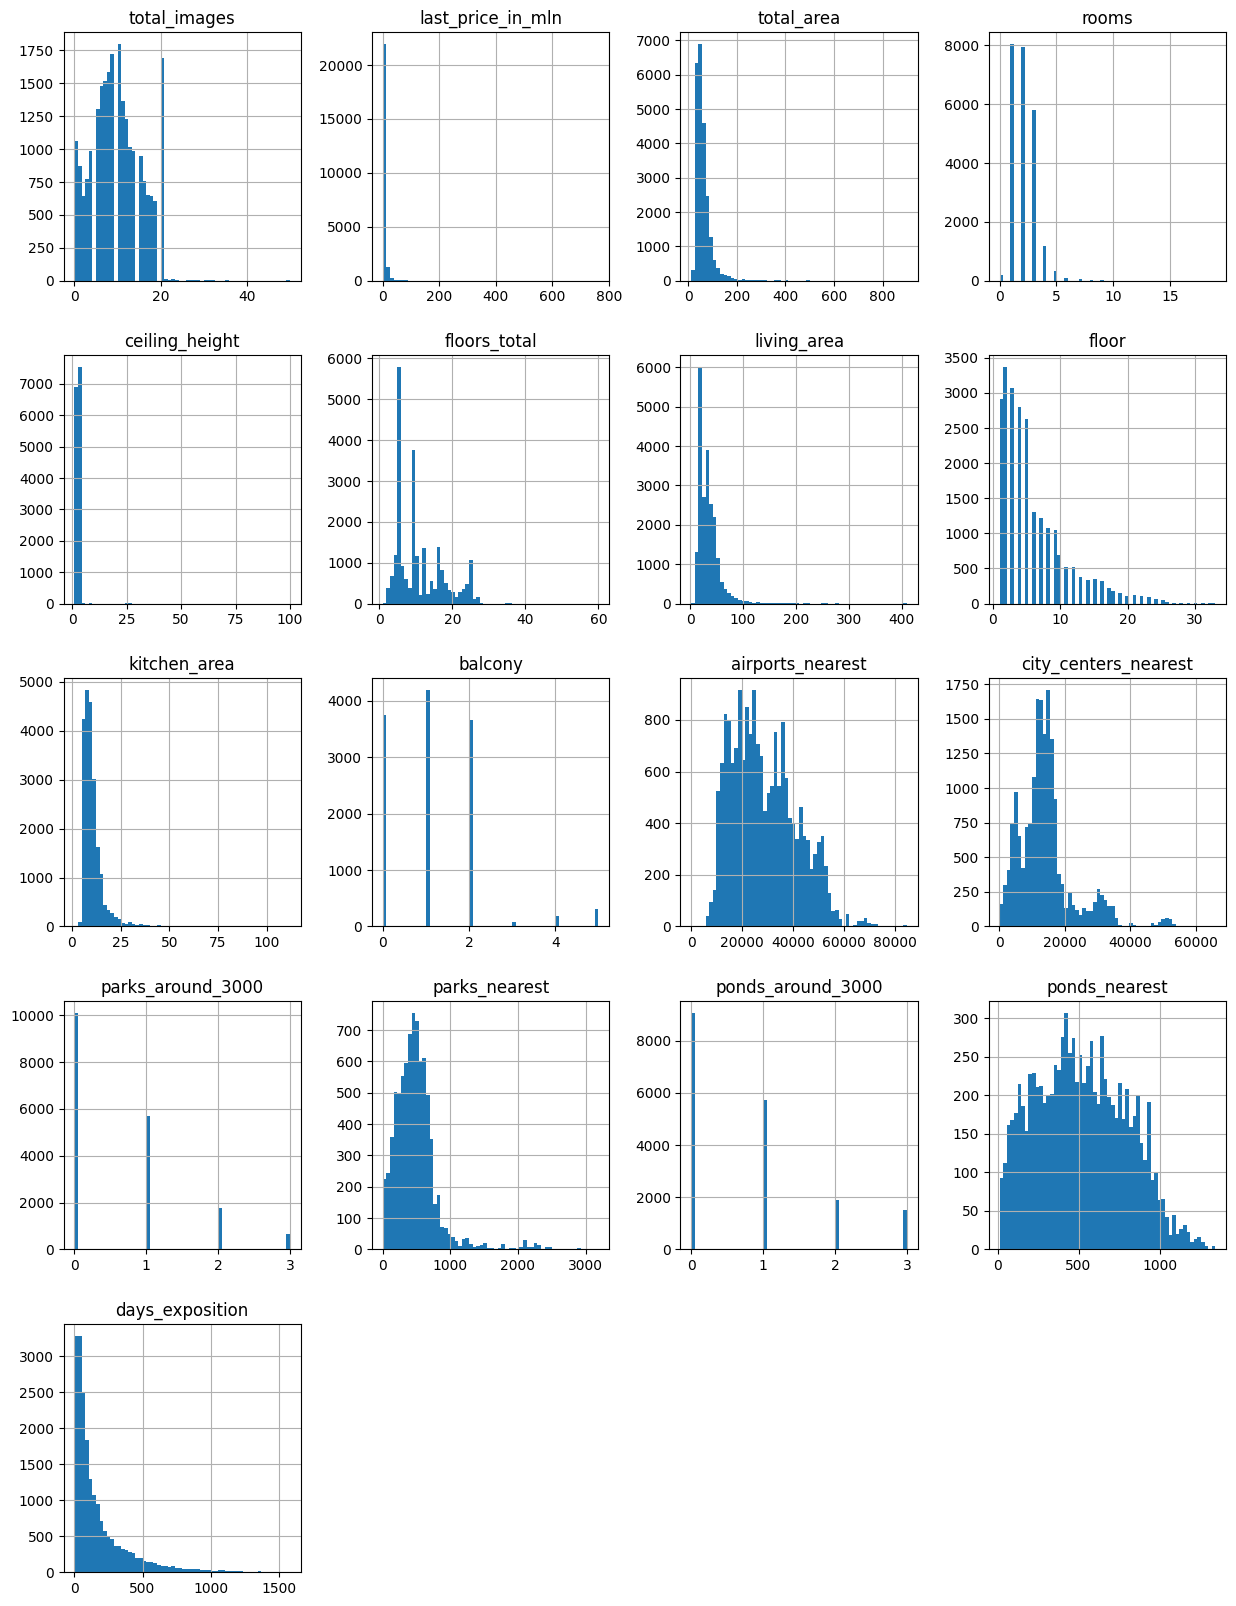

In [3]:
data.hist(bins=60, figsize=(15,20));

* _Стоимость:_ доминирующая доля объектов стоит до 50 млн руб., однако, судя по горизонтальной оси, выдающейся до 800 млн руб., в выборке присутствуют аномально дорогие объекты. 
* _Общая площадь:_ распределение до 200 кв.м. выглядит адекватно, с пиком ок. 70 кв.м. Однако, судя по горизонтальной оси, выдающейся за 800 кв.м., в выборке присутстуют аномально большие по площади объекты.
* _Количество комнат:_ ок. 67% объектов в выборке - это одно- и двухкомнатные квартиры. В выборке присутстуют объекты с нулем комнат, необходимо понять, что это за объекты (скорее всего, так обозначены студии). Также присутстуют объекты с количеством комнат больше 7. Возможно, это аномально большие по площади объекты (см. выше).
* _Высота потолков:_ судя по горизонтальной оси, в выборке присутстсуют выбросы (высота от 10 до 100 м). Необходимо устранить аномалии. Наиболее частотные показатели - от 2,5 до 2,8 м, что выглядит логично для типовой застройки.

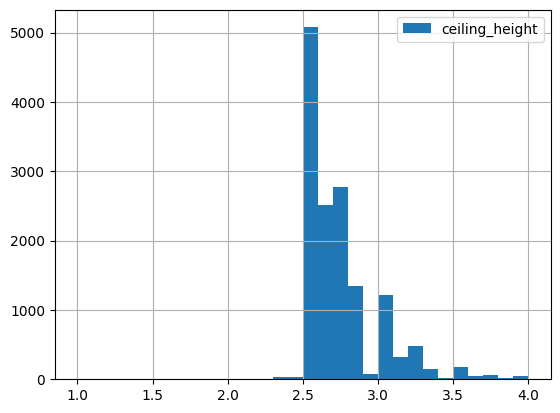

In [4]:
data.query('ceiling_height <= 4')['ceiling_height'].hist(bins=30, legend=True);

* _Кол-во этажей в доме:_ распределение не похоже на нормальное или Пуассоновское, присутстуют 6 пиков (самые частотные - дома на 5 и 9-10 этажей). Вероятно, такое распределение связано с особенностями застройки городов. Судя по горизонтальной оси, присутстуют аномально высокие строения (более 40 этажей). Возможно, это небоскребы (напр., объекты в Лахта-центре (88 этажей)). Однако настолько высотная застройка не характерна для Санкт-Петербурга, поэтому, скорее всего, эти данные нужно исключить из рассмотрения. Объекты с нулем этажей отсутствуют.
* _Жилая площадь:_ распределение похоже на Пуассоновское, но с двумя пиками (возможно, это площади серийных одно- и двухкомнатных квартир, но подобные пики не наблюдались на распределении общей площади).
* _Этаж_: распределение выглядит логично, бОльшая часть объектов расположена на 1-5 этажах (соотносится с пиком общей этажности на 5 этажах).
* _Площадь кухни:_ по аналогии с другими показателями площади, есть аномально большие значения. Присутствует незначительное количество объектов с площадью кухни от 1 до 4 кв.м. (см. отдельную гистограмму).

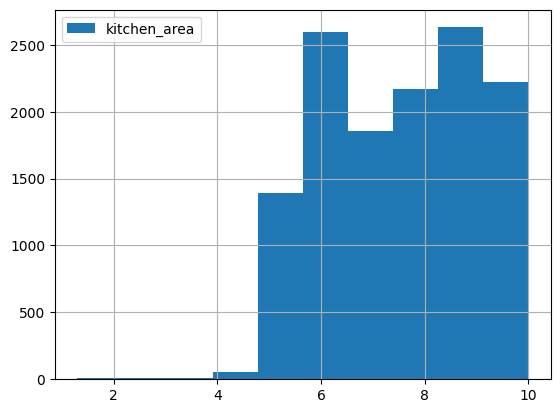

In [5]:
data.query('kitchen_area <= 10')['kitchen_area'].hist(bins=10, legend=True);

* _Количество балконов_: вызывают подозрения объекты с более, чем четырьмя балконами. Возможно, это аномально большие по площади объекты.
* _Расстояние до ближайшего аэропорта:_ в выборке есть незначительное количество объектов с расстоянием до аэропорта ок. 1 км. Скорее всего, это ошибочные данные, т.к. вокруг аэропортов обычно есть "зоны отчуждения". В остальном гистограмма соответствует ожиданиям.

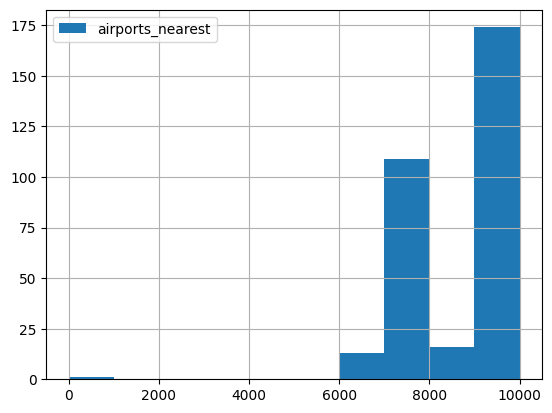

In [6]:
data.query('airports_nearest <= 10000')['airports_nearest'].hist(bins=10, legend=True);

* _Расстояние до центра города:_ в распределении присутствуют 3-4 пика (крупнейший на уровне 10-15 км). Возможно, такое распределение связано с неравномерной плотностью застройки территорий, или для ближайших агломераций указан не центр агломерации, а центр Санкт-Петербурга.
* _Кол-во парков (прудов) в пределах 3 км:_ данные выглядят логично. Крупнейшими категориями в выборке являются объекты, пределах 3 км от которых нет парка (пруда).
* _Расстояние до ближайшего парка (пруда):_ согласно гистограммам, ближайший парк (пруд) находится в основном в пределах 1 км от объекта, что противоречит гистограммам по кол-ву парков и прудов в радиусе 3 км. Однако нужно учесть, что данные по расстоянию представлены только по 8-9 тыс.наблюдений из 23 тыс. в выборке, возможно, эти данные присутствуют только для тех объектов, где в радиусе есть хотя бы один парк (пруд), или эти данные дополняют информацию о кол-ве парков (прудов) в радиусе.
* _Срок размещения объявления:_ распределение выглядит адекватно (похоже на Пуассоновское), большинство объявлений снимались с публикации в срок до 250 дней (ок. 8 мес.); есть "хвост" долгих объявлений.

### Вывод

В исходной выборке представлено ок. 24 тыс. наблюдений и 22 показателя. При этом в 15 из 22 показателей есть пропуски, в т.ч. и в картографических данных. Т.е. нельзя сказать, что пропуски появлялись только на этапе заполнения полей пользователем. Также в данных присутствуют выбросы, наиболее критичные аномалии - слишком большие значения стоимости (свыше 100 млн руб.) и размера помещения (общая площадь свыше 200 кв. м, количество комнат больше 6). 

Для дальнейшего анализа и улучшения надежности выводов необходима обработка данных.

## Предобработка данных

### Заполнение пропусков

Рассмотрим, какую долю от количества наблюдений (в процентах) составляют пропуски в тех или иных данных:

In [7]:
pd.DataFrame(round(data.isna().mean()*100,3)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price_in_mln,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.799000
floors_total,0.363000
living_area,8.030000
floor,0.000000
is_apartment,88.291000


Заметим, что количество пропусков в колонках `floors_total` и `locality_name` не превышают 0,5% данных. Таким образом, строками с отсутствующей локацией можно пренебречь, а строки с отсутствующей общей этажностью заполнить медианным, либо другим консенсусным значением несмотря на неравномерность распределения данных.

Количество пропусков в других данных существенно, необходимо понять их характер и заполнить их (по возможности). Рассмотрим каждый столбец в отдельности.

#### Высота потолков

Как было отмечено ранее, более половины значений в выборке лежат в интервале от 2,5 до 3 м, что выглядит реалистично. При этом нельзя сказать, что высота потолка в помещении зависит от локации, этажности дома или каких-то других имеющихся данных, поэтому представляется логичным заполнить пропуски медианным значением для всей выборки.

In [8]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

#### Общая этажность дома

Количество пропусков в данных невелико (ок. 0,4%), поэтому предлагается заполнить недостающие значения медианой несмотря на наличие нескольких резких пиков в распределении. Такая замена не исказит данные, но и не приведет к потере другой информации.

In [9]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

#### Жилая площадь и площадь кухни 

Жилая площадь зависит от общей площади квартиры и её доля в общей площади должна расти по мере увеличения комнатности (т.к. добавление комнаты при прочих равных добавляет только жилую площадь). Аналогично, доля площади кухни должна сокращается по мере роста комнатности.

Данные об общей площади и количестве комнат представлены для всей выборки.

Таким образом, предлагается заполнить пропуски в этих данных исходя из медианной доли жилплощади и кухни в общей площади квартиры для каждого количества комнат.

In [10]:
# Рассчитаем медианные доли жилплощади и кухни для каждого кол-ва комнат:
area_shares = data.pivot_table(index='rooms', values=['total_area', 'living_area', 'kitchen_area'], aggfunc='median')
area_shares['living_share'] = area_shares['living_area'] / area_shares['total_area']
area_shares['kitchen_share'] = area_shares['kitchen_area'] / area_shares['total_area']
area_shares.loc[0,'kitchen_share'] = area_shares.loc[1,'kitchen_share'] #для пропущенного значения для студий возьмем долю однокомнатной

# Заполним пропуски в данных о жилплощади:
for t in data['rooms'].unique():
    data.loc[(data['rooms']==t) & (data['living_area'].isna()), 'living_area'] = \
    data['total_area'] * area_shares.loc[t,'living_share'] # умножаем фактическую общую площадь на соотв.медианную долю жилплощади
# Заполним пропуски в данных о площади кухни:
for f in data['rooms'].unique():
    data.loc[(data['rooms']==f) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data['total_area'] * area_shares.loc[f,'kitchen_share'] # умножаем фактическую общую площадь на соотв.медианную долю кухни

#### Признак апартаментов

Скорее всего, пользователь не заполнил поле с признаком апартаментов потому, что объект ими не является. Таким образом, заполнение пропусков значением, означающим "не апартаменты", будет оправдано. 

Вместе с тем, тип данных был автоматически определен как *object*. Рассмотрим уникальные значения в столбце:

In [11]:
print('Уникальные значения в колонке "is_apartment":', data['is_apartment'].unique())

Уникальные значения в колонке "is_apartment": [nan False True]


Видим, что не пустые ячейки заполнены булевым типом данных, "не апартаменты" обозначены как *False*. Однако NaN относится к числовому типу, что привело к автоопределению колонки как *object*. Т.е. заполнение пропусков автоматически переопределит тип данных.

Заполним пропуски:

In [12]:
data['is_apartment'] = data['is_apartment'].fillna(False)
print('Тип после заполнения пропусков:', data['is_apartment'].dtype)

Тип после заполнения пропусков: bool


#### Количество балконов

Как и в случае с флагом апартаментов, пропуск в данных скорее всего означает, что в квартире нет балкона. Исходя из этого, заполним пропуски значением "0".

In [13]:
data['balcony'] = data['balcony'].fillna(0)

#### Название населенного пункта

Не представляется возможным определить пропущенные значения из имеющихся данных, кроме того, доля пропусков несущественна. Поэтому представляется разумным исключить такие наблюдения из выборки.

In [14]:
data = data.dropna(subset=['locality_name'])

#### Расстояния до центра, ближайшего аэропорта, количество парков и водоемов в пределах 3 км

Пропуски в каждом из указанных столбцов составляют почти четверть от общего числа наблюдений, поэтому удаление этих наблюдений приведет к потере большого количества информации. Посчитаем, в скольких наблюдениях пропущены все 4 параметра:

In [15]:
selection = ((data['airports_nearest'].isna()) & 
             (data['city_centers_nearest'].isna()) &
             (data['parks_around_3000'].isna()) &
             (data['ponds_around_3000'].isna())
            )
print('Доля строк с пропусками в четырех столбцах:', len(data[selection]) / len(data))     

Доля строк с пропусками в четырех столбцах: 0.23298097251585623


Судя по тому, что доля строк с пропусками во всех четырех столбцах не отличается от доли пропусков в каждом столбце по отдельности, можно сделать вывод, что это преимущественно одни и те же строки. Возможно, наличие пропуска в них связано с тем, что не указан точный адрес объекта.

Заполним пропуски в расстоянии до центра города и до аэропорта медианными значениями для каждого населенного пункта. Оставшиеся пропуски (если таковые будут) не будем изменять или удалять. При этом, если о расстоянии до центра или аэропорта можно примерно судить, исходя из названия населенного пункта, восстановить данные о количестве парков и водоемов в радиусе 3 км не представляется возможным. В связи с этим оставим эти данные как есть.

In [16]:
warnings.filterwarnings('ignore')
for location in data['locality_name'].unique():
    median_city = data.loc[data['locality_name']==location, 'city_centers_nearest'].median()
    median_airport = data.loc[data['locality_name']==location, 'airports_nearest'].median()
    data.loc[(data['locality_name']==location) & (data['city_centers_nearest'].isna()), 'city_centers_nearest'] = median_city
    data.loc[(data['locality_name']==location) & (data['airports_nearest'].isna()), 'airports_nearest'] = median_airport

#### Расстояние до ближайшего парка (водоема)

Пропуски в каждом из столбцов составляют более 60% всей выборки. Проверим, как соотносятся строки с пропусками в анализируемых столбцах, а также с пропусками в данных о наличии парка (водоема) в пределах 3 км. Возможно, это поможет выяснить природу этих пропусков и найти вариант их заполнения.

In [17]:
print('Доля строк с пропусками в обоих рассматриваемых столбцах:', 
      len(data[(data['parks_nearest'].isna()) & (data['ponds_nearest'].isna())])/len(data))

print('Доля строк с пропусками и в расстоянии, и в количестве парков:', 
      len(data[(data['parks_nearest'].isna()) & (data['parks_around_3000'].isna())])/len(data))

print('Доля строк с пропусками и в расстоянии, и в количестве водоемов:', 
      len(data[(data['ponds_nearest'].isna()) & (data['ponds_around_3000'].isna())])/len(data))

Доля строк с пропусками в обоих рассматриваемых столбцах: 0.4784778012684989
Доля строк с пропусками и в расстоянии, и в количестве парков: 0.23298097251585623
Доля строк с пропусками и в расстоянии, и в количестве водоемов: 0.23298097251585623


Видим, что в данных, где пропущена информация о наличии парка (водоема) в радиусе 3 км, отсутствует и расстояние до ближайшего парка (водоема). При этом строки, где отсутствуют расстояния до парка или водоема пересекаются, но не полностью. 

Проверим предположение, что расстояние до парка (водоема) рассчитывается только для тех объектов, где в радиусе 3 км есть хотя бы один парк (водоем):

In [18]:
print('Количество строк, где есть хотя бы один парк:', 
      len(data[(data['parks_around_3000'] != 0) & ~(data['parks_around_3000'].isna())])
     )
print('Количество строк, где есть хотя бы один парк и указано расстояние:', 
      len(data[(data['parks_around_3000'] != 0) & ~(data['parks_around_3000'].isna()) & ~(data['parks_nearest'].isna())])
     )
print('Количество строк, где нет парка и указано расстояние:',
     len(data[((data['parks_around_3000'] == 0) | (data['parks_around_3000'].isna())) & ~(data['parks_nearest'].isna())])
     )
print('--------------')
print('Количество строк, где есть хотя бы один водоем:', 
      len(data[(data['ponds_around_3000'] != 0) & ~(data['ponds_around_3000'].isna())])
     )
print('Количество строк, где есть хотя бы один водоем и указано расстояние:', 
      len(data[(data['ponds_around_3000'] != 0) & ~(data['ponds_around_3000'].isna()) & ~(data['ponds_nearest'].isna())])
     )
print('Количество строк, где нет водоема и указано расстояние:',
     len(data[((data['ponds_around_3000'] == 0) | (data['ponds_around_3000'].isna())) & ~(data['ponds_nearest'].isna())])
     )

Количество строк, где есть хотя бы один парк: 8060
Количество строк, где есть хотя бы один парк и указано расстояние: 8060
Количество строк, где нет парка и указано расстояние: 4
--------------
Количество строк, где есть хотя бы один водоем: 9085
Количество строк, где есть хотя бы один водоем и указано расстояние: 9085
Количество строк, где нет водоема и указано расстояние: 0


Наше предположение о природе данных в столбцах `parks_nearest` и `ponds_pearest` с высокой долей вероятности верно. Значит, пропуски в этих данных объясняются как отсутствием парка (водоема) в пределах 3 км, так и причинами, вызвавшими пропуски в других картографических данных (одна из возможных - не указан точный адрес объекта).

Пропуски, вызванные отсутсвием парка (водоема), можно было бы заполнить "заглушками" (напр., 99999999). Однако это сильно исказит распределение и может привести к смещениям в регрессионной модели. Для пропусков, вызванных отсутствием данных о наличии парка (водоема), сложно предложить логичную замену.

#### Срок размещения объявления

Пропуски составляют ок. 13% от общего числа наблюдений. Сложно предположить бизнес-причину, приводящую к пропуску в такой информации, поскольку она, скорее всего, формируется автоматически платформой (как и количество фото в объявлении). 

Также сложно однозначно определить, от чего зависит срок размещения объявления (на показатель влияют соотношение цена-качество, экономическая ситуация, уровень ставки по ипотеке, наличие обремений и т.п.). Иначе говоря, в рамках текущей задачи сложно найти логичный дифференцированный подход к заполнению пропусков без построения модели. Поэтому предлагается заполнить пропуски медианным значением по выборке.

In [19]:
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

### Преобразование типов данных

Преобразуем форматы столбцов `firt_day_exposition` из *object* в *datetime* для упрощения дальнейшей работы с этой информацией. Столбец `is_apartment` был автоматически преобразован в *bool* при заполнении пропусков. 

Также переведем колонки `floors_total`, `balcony` в целочисленный тип. Столбцы `parks_around_3000` и `ponds_around_3000` нельзя конвертировать в целые числа из-за оставшихся пропусков. 

In [20]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition']) 
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')

### Устранение неявных дубликатов

Устраним неявные дубликаты в названии населенных пунктов (остальные данные являются либо количественными, либо не предполагают вариаций в написании).

In [21]:
display(data['locality_name'].value_counts().head(20)) # рассмотрим 20 наиболее частотных названий,...
print('Количество уникальных наименований:', data['locality_name'].nunique()) # количество ...
print('--------------')
print(data['locality_name'].unique()) #... и список уникальных значений

Санкт-Петербург            15721
посёлок Мурино               522
посёлок Шушары               440
Всеволожск                   398
Пушкин                       369
Колпино                      338
посёлок Парголово            327
Гатчина                      307
деревня Кудрово              299
Выборг                       237
Петергоф                     201
Сестрорецк                   183
Красное Село                 178
Кудрово                      173
деревня Новое Девяткино      144
Сертолово                    142
Ломоносов                    133
Кириши                       125
Сланцы                       112
Волхов                       111
Name: locality_name, dtype: int64

Количество уникальных наименований: 364
--------------
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никол

Видим, что список уникальных наименований довольно большой (364 элемента), но количество объявлений для населенных пунктов ниже топ-20 менее 100. Также заметим, что дубликаты возникают не в непосредственном названии населенного пункта, но в наличии/отсутствии или написании вспомогательных слов (деревня, поселок и т.д.). Нельзя сказать, что города указываются без слова "город", а менее крупные населенные пункты - с указанием их вида (напр., есть "деревня Кудрово" и "Кудрово"). Значит, можно избавиться от неявных дубликатов, устранив названия типов населенных пунктов. Также заметим, что непосредственные названия начинаются с большой буквы, значит, можно удалить все элементы строки до первого заглавного символа.

In [22]:
# Создадим функцию, возвращающую подстроку, начиная с первого заглавного символа:
def unified_naming(name):
    i = 0
    while (name[i].islower() or name[i]==' '): # ищем первой заглавный символ перебором по строке
        i +=1;
    return name[i:len(name)] # возвращаем строку от найденного символа до конца строки

# Применим функцию к данным:
data['locality_name'] = data['locality_name'].apply(unified_naming)
print('Количество уникальных наименований:', data['locality_name'].nunique())

Количество уникальных наименований: 305


В результате избавились от ок. 60 неявных дубликатов в написании населенных пунктов.

### Работа с аномалиями

Как описывалось в п.2.1., в данных есть выбросы, которые нужно устранить для дальнейшего анализа. Рассмотрим каждый параметр в отдельности. Начнем рассмотрение с общей площади объектов, поскольку это основной фактор, влияющий на стоимость.

Перед этим оптимизируем подсчет количества и доли аномальных наблюдений в выборке.

In [23]:
def outlier_count(series, limit_high, limit_low=0):
    count_low = series.loc[series < limit_low].count()
    count_high = series.loc[series > limit_high].count()
    count = count_low + count_high
    share = count / len(series)
    return (count, share)

#### Общая площадь

Рассмотрим описательную статистику распределения и диаграмму размаха.

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

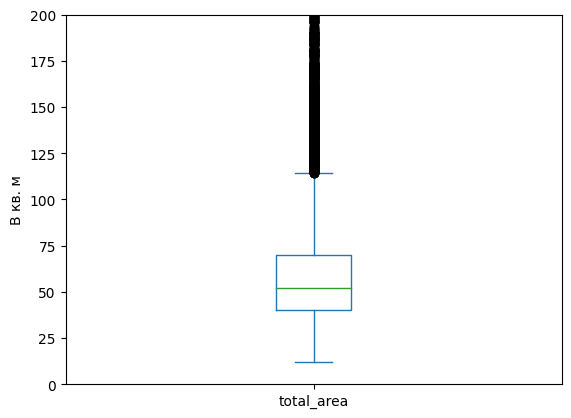

In [24]:
display(data['total_area'].describe())
data['total_area'].plot(kind='box', ylim=(0, 200), ylabel='В кв. м'); # ограничили вертикальнцую ось для читаемости графика

Медианное значение площади составляет 52 кв. м, а среднее - 60 кв. м, что говорит о том, что распределение смещено вправо из-за выбросов (максимальное значение достигает 900 кв. м).

Рассмотрим топ-10 по площади объектов:

In [25]:
display(data.sort_values('total_area', ascending=False).head(10))

,total_images,last_price_in_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
19540,8,420.0,900.0,2017-12-06,12,2.80,25,409.700000,25,False,...,112.000000,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
12859,20,140.0,631.2,2019-04-09,7,3.90,4,322.300000,4,False,...,19.500000,1,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,95.0
3117,19,140.0,631.0,2019-03-30,7,2.65,5,427.546729,5,False,...,60.000000,0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,95.0
15651,20,300.0,618.0,2017-12-18,7,3.40,7,258.000000,5,False,...,70.000000,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
5358,20,65.0,590.0,2019-02-14,15,3.50,6,409.000000,3,False,...,100.000000,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
4237,1,50.0,517.0,2017-10-14,7,2.65,4,332.000000,3,False,...,22.000000,0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,95.0
8018,20,84.0,507.0,2015-12-17,5,4.45,7,301.500000,7,True,...,45.500000,1,Санкт-Петербург,26757.5,5735.0,2.0,110.0,0.0,NaN,1078.0
15016,8,150.0,500.0,2016-01-13,4,3.20,7,320.241692,7,False,...,55.891239,0,Санкт-Петербург,33058.0,6150.0,3.0,209.0,3.0,531.0,303.0
5893,3,230.0,500.0,2017-05-31,6,2.65,7,336.136734,7,False,...,40.000000,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
12401,20,91.5,495.0,2017-06-19,7,4.65,7,347.500000,7,False,...,25.000000,0,Санкт-Петербург,26757.5,5735.0,2.0,110.0,0.0,NaN,14.0


Судя по количеству комнат, высоте потолков и т.п., такие большие значения площади едва ли являются технической ошибкой (напр., 90, а не 900 кв. м), скорее, это действительно аномально большие по сравнению с остальной выборкой объекты. Значит, необходимо исключить их из рассмотрения для дальнейшего анализа. Возможно, это несопоставимые объекты (напр., частный дом, а не квартира), что и приводит к таким аномалиям. Согласно диаграмме размаха, выбросами можно считать объекты площадью более 120 кв. м. Однако исходя из здравого смысла, аномальным скорее являются объекты более 200 кв. м. Найдем их количество и долю в выборке:

In [26]:
total_area_outliers = outlier_count(data['total_area'], 200)
print('Количество выбросов составляет {0}, или {1}% от общего числа наблюдений.'.
      format(total_area_outliers[0], round(total_area_outliers[1]*100, 1)))

Количество выбросов составляет 227, или 1.0% от общего числа наблюдений.


Количество выбросов невелико (ок. 5% выборки), поэтому можно их удалить. Однако данные могут потребоваться, если подтвердится предположение о их несопоставимости с общей выборкой, поэтому сохраним их в отдельный массив данных.

In [27]:
data_abnormal_area = data.query('total_area > 200') # выделили аномальные значения в отдельную переменную
data = data.query('total_area <= 200') # удалили выбросы из основной выборки

#### Стоимость объекта

Как описывалось ранее, ок. 15 тыс. наблюдений относятся к объектам в Санкт-Петербурге, остальные - к объектам в близлежайших населенных пунктах. Скорее всего, стоимость аналогичных объектов в СПб и любом другом населенном пункте будет различна за счет доступности инфраструктуры и т.д. Поэтому предлагается рассмотреть две отдельные диаграммы размаха для объектов в СПб и всех прочих объектов. 

,Санкт-Петербург,Прочие
count,15508.00000,7915.000000
mean,7.31701,3.492951
std,7.20190,1.989934
min,0.01219,0.430000
25%,4.20000,2.350000
50%,5.50000,3.180000
75%,7.99000,4.200000
max,330.00000,29.500000


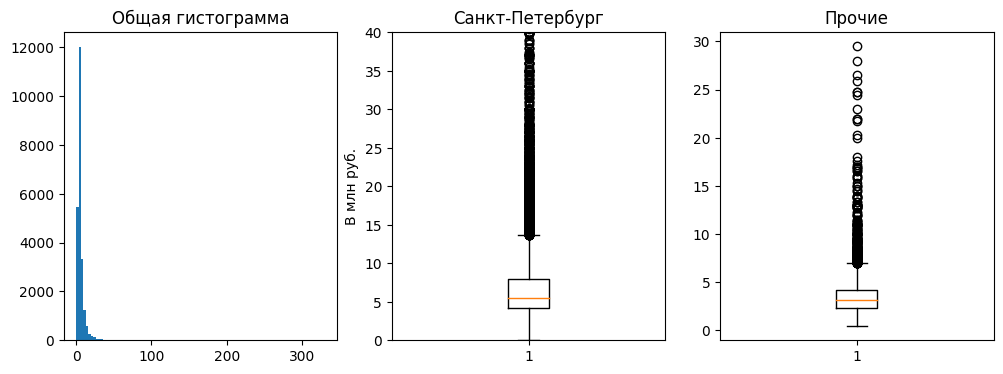

In [28]:
# Создадим таблицу для визуализации описательной статистики (отдельно для СПб и прочих населенных пунктов)
descr_stats = pd.DataFrame(index=data['last_price_in_mln'].describe().index)
descr_stats['Санкт-Петербург'] = data.query('locality_name == "Санкт-Петербург"')['last_price_in_mln'].describe()
descr_stats['Прочие'] = data.query('locality_name != "Санкт-Петербург"')['last_price_in_mln'].describe()
display(descr_stats)

# Построим диаграммы размаха (отдельно для СПб и прочих населенных пунктов)
fig, axs = plt.subplots(1, 3, figsize = (12,4))
axs[0].hist(data['last_price_in_mln'], bins=100)
axs[0].set_title('Общая гистограмма')
axs[1].boxplot(data.query('locality_name == "Санкт-Петербург"')['last_price_in_mln'])
axs[1].set_title('Санкт-Петербург')
axs[1].set_ylabel('В млн руб.')
axs[1].set_ylim(0, 40) # ограничим ось для читаемости графика
axs[2].boxplot(data.query('locality_name != "Санкт-Петербург"')['last_price_in_mln'])
axs[2].set_title('Прочие')
plt.show()

Видим, в выборке остаются значения, превышающие 100 млн руб. При этом за пределами межквартильного размаха для Санкт-Петербурга оказываются значения со стоимостью более ок. 13 млн руб., для прочих населенных пунктов - стоимостью более ок. 8 млн руб. 

Для понимания, насколько аномальными являются цены, рассчитаем стоимость квадратного метра, и найдем количество объявлений, где цена квадратного метра аномальна (так мы избавимся от влияния общей площади на стоимость). 

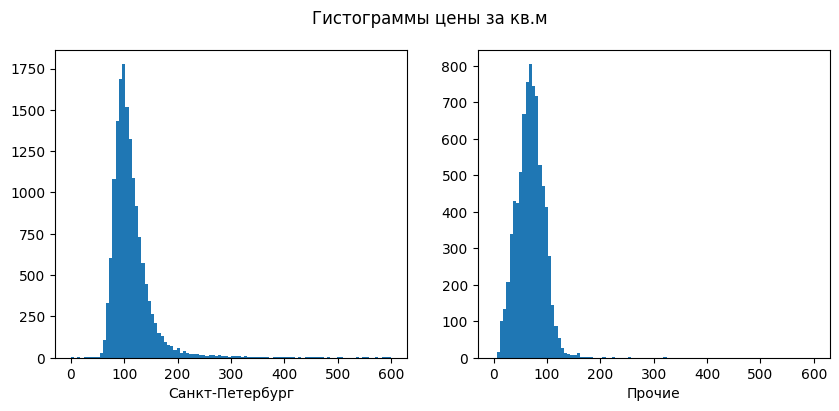

In [29]:
data['price_per_sqm_thousand'] = data['last_price_in_mln'] / data['total_area'] * 1000 # цена за кв. м в тыс. руб.

fig, axs = plt.subplots(1,2, figsize = (10, 4))
axs[0].hist(data.loc[data['locality_name']=='Санкт-Петербург', 'price_per_sqm_thousand'], bins=100, range=(0,600))
axs[0].set_xlabel('Санкт-Петербург')
axs[1].hist(data.loc[data['locality_name']!='Санкт-Петербург', 'price_per_sqm_thousand'], bins=100, range=(0,600))
axs[1].set_xlabel('Прочие')
fig.suptitle('Гистограммы цены за кв.м')
plt.show()

Видим, что распределения цены за кв. м стремятся к нормальному, пик для СПб находится правее, чем для прочих населенных пунктов (что ожидаемо). При этом есть правый "хвост" с околоноулевой частотностью. Найдем количество объявлений, цена за кв. м которых выше 300 тыс.руб. (для СПб) и 200 тыс.руб. (для прочих населенных пунктов):

In [30]:
price_outliers = (outlier_count(data.loc[data['locality_name']=='Санкт-Петербург','price_per_sqm_thousand'], 300)[0] + # для СПб
                 outlier_count(data.loc[data['locality_name']!='Санкт-Петербург','price_per_sqm_thousand'], 200)[0]) # для прочих

print('Количество выбросов равно {0}, или {1}% от общего числа наблюдений.'.format(
price_outliers, round(price_outliers / len(data) *100, 3))
     )

Количество выбросов равно 134, или 0.572% от общего числа наблюдений.


Количество таких выбросов незначительно, ими можно пренебречь.

In [31]:
data = data[((data['locality_name'] == 'Санкт-Петербург') & # Для СПб цена за кв. м не выше 300 тыс.руб.,... 
            (data['price_per_sqm_thousand'] < 300)) |
            ((data['locality_name'] != 'Санкт-Петербург') & # Для прочих цена за кв. м не выше 200 тыс.руб.
             (data['price_per_sqm_thousand'] < 200))]

#### Количество комнат

Построим гистограмму и диаграмму размаха для показателя.

count    23287.000000
mean         2.029287
std          0.993797
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64


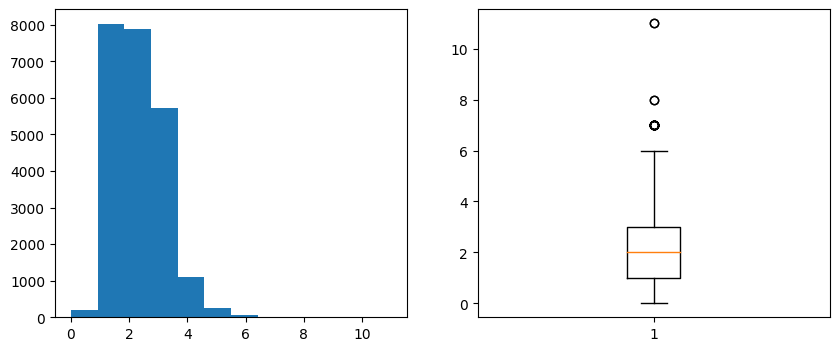

In [32]:
print(data['rooms'].describe())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(data['rooms'], bins=12)
axs[1].boxplot(data['rooms'])
plt.show()

Видно, что присутствует незначительное количество объектов, где указано 0 комнат. Скорее всего, так обозначены студии. Убедимся, что нулем комнат обозначены студии:

In [33]:
display(data.query('rooms == 0').sort_values('total_area', ascending=False).head())
print('Минимальная площадь: {0} кв. м, максимальная - {1} кв.м.'.format(
data.query('rooms == 0')['total_area'].min(), data.query('rooms == 0')['total_area'].max())
     )

,total_images,last_price_in_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_sqm_thousand
20082,10,16.30,98.4,2017-11-08,0,3.10,5,60.5,2,False,...,0,Санкт-Петербург,26972.0,5819.0,0.0,NaN,1.0,674.0,537.0,165.650407
3458,6,7.40,73.6,2017-05-18,0,2.65,3,50.0,1,False,...,0,Санкт-Петербург,26581.0,6085.0,0.0,NaN,1.0,348.0,60.0,100.543478
21227,0,8.20,71.0,2017-07-21,0,5.80,5,68.0,5,False,...,0,Санкт-Петербург,20170.0,1261.0,2.0,295.0,3.0,366.0,30.0,115.492958
13613,16,8.10,58.4,2019-04-26,0,3.30,7,33.0,6,False,...,0,Санкт-Петербург,14509.0,8288.0,0.0,NaN,0.0,NaN,95.0,138.698630
10008,20,5.05,44.2,2017-09-14,0,2.70,9,32.2,1,False,...,0,Санкт-Петербург,24329.0,5955.0,0.0,NaN,2.0,520.0,69.0,114.253394


Минимальная площадь: 15.5 кв. м, максимальная - 98.4 кв.м.


Подозрительно выглядит объект с нулем комнат и площадью около 100 кв. м. Однако поиск объявлений на Циан показал, что такие объекты бывают, поэтому не будем считать объявления с 0 комнат аномалиями.

Найдем количество объектов, число комнат в котгорых больше 6 (сообразно диаграмме размаха):

In [34]:
rooms_outliers = outlier_count(data['rooms'], 6)
print('Количество выбросов равно {0}, или {1}% от общего числа наблюдений.'.format(
rooms_outliers[0], round(rooms_outliers[1] * 100, 3))
     )

Количество выбросов равно 24, или 0.103% от общего числа наблюдений.


Количество выбросов ничтожно, ими можно пренебречь.

In [35]:
data = data.query('rooms <= 6')

#### Высота потолков

Рассмотрим описательную статистику и диаграмму размаха.

count    23263.000000
mean         2.713932
std          0.762361
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64

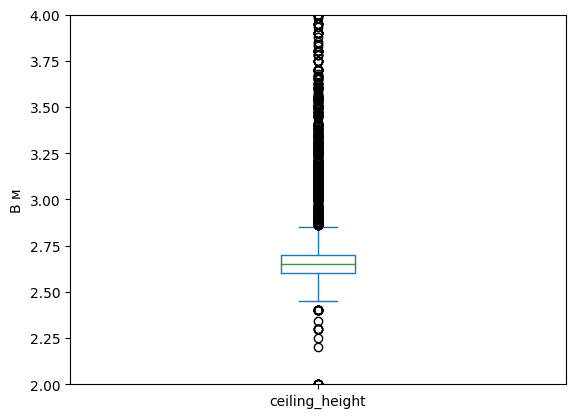

In [36]:
display(data['ceiling_height'].describe())
data['ceiling_height'].plot(kind='box', ylim=(2, 4), ylabel='В м');

В распределении присутствуют аномально малые значение (менее 2,5 м) и аномально высокие значения (более 3 м). Максимальное значение составляет 32 м. 
Рассмотрим подробнее аномально высокие значения:

In [37]:
display(data.sort_values('ceiling_height', ascending=False).head(10))

,total_images,last_price_in_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_per_sqm_thousand
22336,19,9.999,92.4,2019-04-05,2,32.0,6,55.5,5,False,...,4,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,95.0,108.214286
3148,14,2.900,75.0,2018-11-12,3,32.0,3,53.0,2,False,...,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,95.0,38.666667
21377,19,4.900,42.0,2017-04-18,1,27.5,24,37.7,19,False,...,2,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0,116.666667
4876,7,3.000,25.0,2017-09-27,0,27.0,25,17.0,17,False,...,2,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0,120.000000
17857,1,3.900,56.0,2017-12-22,3,27.0,5,33.0,4,False,...,0,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0,69.642857
10773,8,3.800,58.0,2017-10-13,2,27.0,10,30.1,3,False,...,2,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0,65.517241
5246,0,2.500,54.0,2017-10-13,2,27.0,5,30.0,3,False,...,2,Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0,46.296296
22938,14,4.000,98.0,2018-03-15,4,27.0,2,73.0,2,True,...,1,Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0,40.816327
21824,20,2.450,44.0,2019-02-12,2,27.0,2,38.0,2,False,...,2,Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,95.0,55.681818
5807,17,8.150,80.0,2019-01-09,2,27.0,36,41.0,13,False,...,5,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,101.875000


Заметим, что значения часто повторяются. Скорее всего, для диапазона в 20-32 м (максимальное значение) была допущена ошибка в отделении дробной части. Заменим эти значения и снова посмотрим на распределение:

count    23263.000000
mean         2.691682
std          0.235977
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

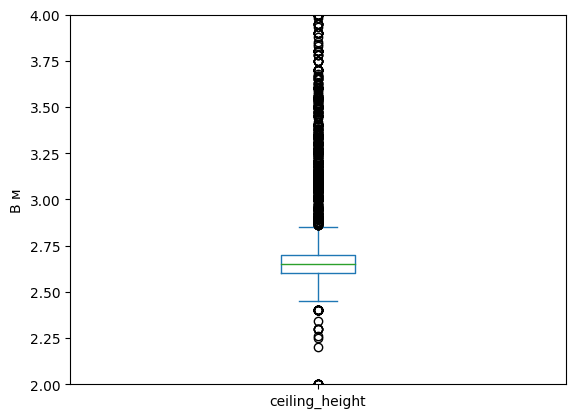

In [38]:
# Заменяем значение:
data.loc[(data['ceiling_height'] >= 20) & (data['ceiling_height'] <= 32),'ceiling_height'] = data['ceiling_height'] / 10

# Выводим описательную статистику и диаграмму размаха:
display(data['ceiling_height'].describe())
data['ceiling_height'].plot(kind='box', ylim=(2, 4), ylabel='В м');

Можно предположить, что высота потолков до 3,5 м не является выбросом, т.к. в зданиях старой нетиповой застройки могут быть высокие потолки. Посчитаем количество выбросов из предположения, что "нормальной" считается высота потолка от 2,5 до 3,5 м:

In [39]:
ceiling_outliers = outlier_count(data['ceiling_height'], 3.5, 2.5)
print('Количество выбросов составляет {0}, или {1}% от общего числа наблюдений.'.format(
    ceiling_outliers[0], round(ceiling_outliers[1]*100, 1))
     )

Количество выбросов составляет 297, или 1.3% от общего числа наблюдений.


Количество аномалий невелико, можно удалить их из выборки.

In [40]:
data = data.query('2.5 <= ceiling_height <=3.5')

#### Жилая площадь и площадь кухни

Рассмотрим распределения указанных параметров.

,Жилплощадь,Площадь кухни
count,22966.000000,22966.000000
mean,32.829099,10.163971
std,16.816447,4.926211
min,2.000000,1.300000
25%,18.600000,7.000000
50%,30.000000,9.000000
75%,41.700000,11.500000
max,164.700000,65.000000


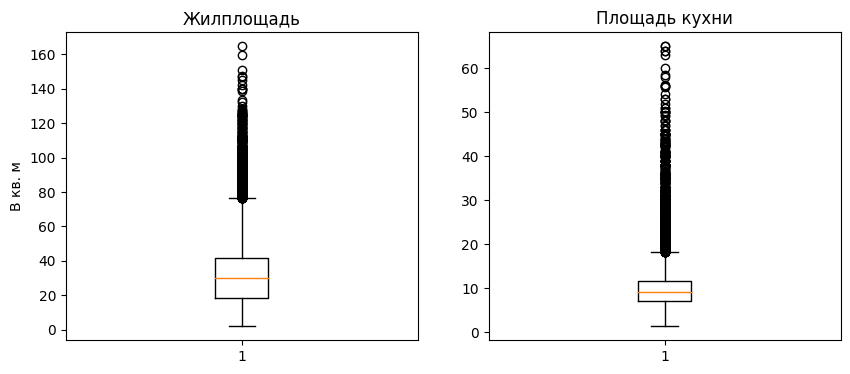

In [41]:
# Таблица для визуализации:
descr_stats = pd.DataFrame(index=data['living_area'].describe().index)
descr_stats['Жилплощадь'] = data['living_area'].describe()
descr_stats['Площадь кухни'] = data['kitchen_area'].describe()
display(descr_stats)
# Диаграммы размаха:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].boxplot(data['living_area'])
axs[0].set_title('Жилплощадь')
axs[0].set_ylabel('В кв. м')
axs[1].boxplot(data['kitchen_area'])
axs[1].set_title('Площадь кухни')
plt.show()

Объекты с площадью кухни более 40 кв. м выглядят подозрительно, исходя из здравого смысла (даже если это кухни-гостиные). Также сомнительны данные по жилплощади более 100 кв. м. Однако эти значения не надежны для определения аномалий. Чтобы найти выбросы, рассчитаем доли жилплощади и площади кухни в общей площади объекта и удалим строки, где доли площадей аномально высоки или малы.

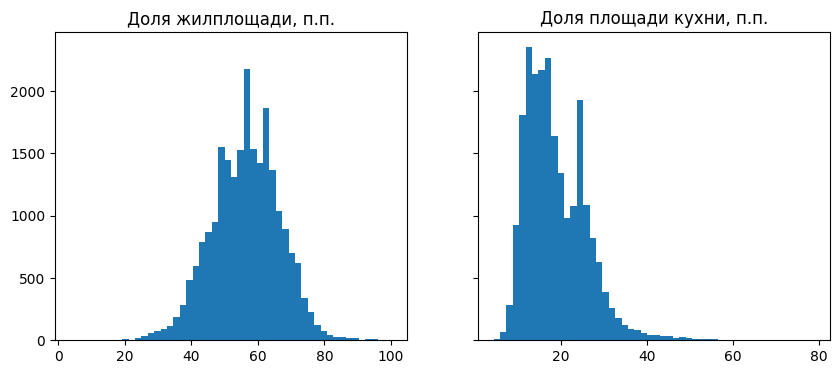

In [42]:
# Посчитаем доли:
data['living_%'] = data['living_area'] / data['total_area'] * 100
data['kitchen_%'] = data['kitchen_area'] / data['total_area'] * 100

#Построим гистограммы:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(10, 4))
axs[0].hist(data['living_%'], bins=50)
axs[0].set_title('Доля жилплощади, п.п.')
axs[1].hist(data['kitchen_%'], bins=50)
axs[1].set_title('Доля площади кухни, п.п.')
plt.show()

Исходя из распределений выше, кажется логичным признать "нормой" объекты, доля жилплощади которых находится в пределах 25-80%, а доля кухни - в интервале 5-40%. Посчитаем, какое количество наблюдений не удовлетворяет данным критериям:

In [43]:
# Зададим фильтр для "нормальных" объектов:
filter_living_kitchen = ((data['living_%'] >= 25) &
                         (data['living_%'] <= 80) &
                         (data['kitchen_%'] >= 5) &
                         (data['kitchen_%'] <= 40)
                        )
# Посчитаем количество выбросов:
print('Количество выбросов равно {0}, или {1}% от общего числа наблюдений.'.format(
      len(data[~filter_living_kitchen]), round(len(data[~filter_living_kitchen]) / len(data) * 100, 3)))

Количество выбросов равно 460, или 2.003% от общего числа наблюдений.


Доля аномальных значений достаточно велика, однако предложить способ замены аномалий затруднительно. Поэтому следует удалить нерелевантные данные. Проверим, остались ли после нормализации "подозрительные объекты:

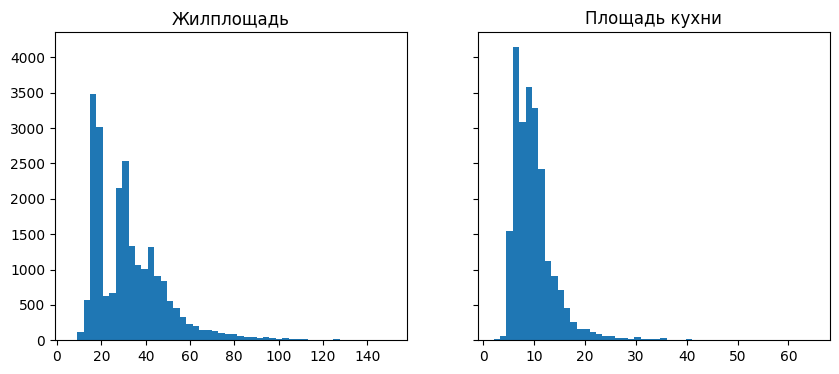

In [44]:
data = data[filter_living_kitchen] # удалили объекты с непропорциональными площадями

#Построим гистограммы:
fig, axs = plt.subplots(1,2, sharey=True, figsize=(10, 4))
axs[0].hist(data['living_area'], bins=50)
axs[0].set_title('Жилплощадь')
axs[1].hist(data['kitchen_area'], bins=50)
axs[1].set_title('Площадь кухни')
plt.show()

В данных еще остались подозрительные объекты. Примем за "норму" жилплощадь не более 120 кв. м и площадь кухни не более 45 кв. м и удалим оставшиеся сомнительные данные.

In [45]:
data = data.query('living_area <= 120 and kitchen_area <=45')

#### Общая этажность в доме
Рассмотрим описательную статистику и диаграмму размаха.

count    22458.000000
mean        10.781013
std          6.598010
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

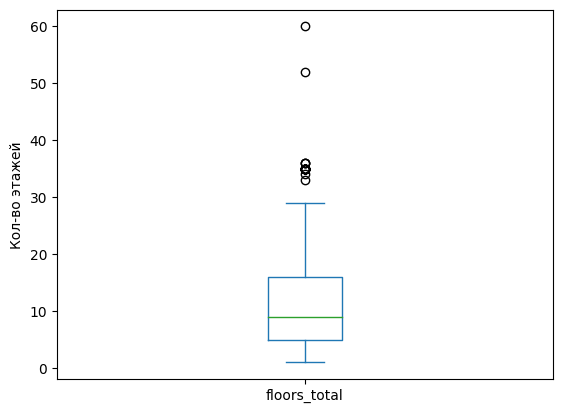

In [46]:
display(data['floors_total'].describe())
data['floors_total'].plot(kind='box', ylabel='Кол-во этажей');

Распределение начинается с единицы, т.е. здания с нулем этажей в выборке отсутствуют. Судя по плотности нанесения выбросов на диаграмму, их немного. Удалим из выборки объекты, общая этажность дома которых превышает 30.

In [47]:
print('Количество выбросов:', outlier_count(data['floors_total'], 30)[0])

data = data.query('floors_total <= 30')

Количество выбросов: 30


#### Количество балконов
Рассмотрим диаграмму размаха показателя.

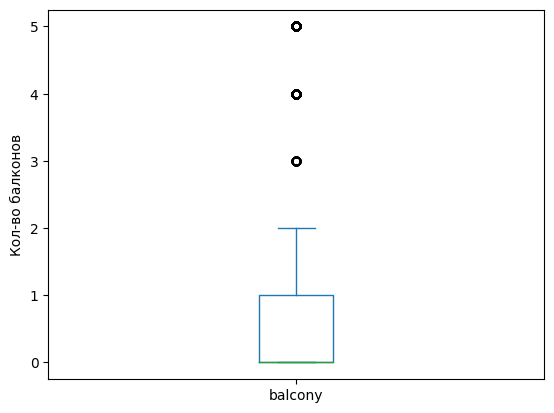

Количество выбросов равно 293, или 1.306% от общего числа наблюдений.


In [48]:
# Построим диаграмму размаха:
data['balcony'].plot(kind='box', ylabel='Кол-во балконов')
plt.show()

# Посчитаем количество выбросов на диаграмме:
print('Количество выбросов равно {0}, или {1}% от общего числа наблюдений.'.format(
    outlier_count(data['balcony'], 4)[0], round(outlier_count(data['balcony'], 4)[1]*100, 3)))

Исходя из здравого смысла, примем за "норму" количество балконов не более 3. Удалим несоответсвующие строки.

In [49]:
data = data.query ('balcony <= 3')

#### Расстояния до центра города и до ближайшего аэропорта

Рассмотрим описательную статистику и диаграммы размаха распределений.

,Расст. до центра,Расст. до аэропорта
count,16834.000000,16834.000000
mean,14540.513098,28972.930320
std,8559.086564,12834.137741
min,181.000000,0.000000
25%,9862.250000,18420.000000
50%,13270.500000,26971.500000
75%,16464.000000,37434.000000
max,65968.000000,84869.000000


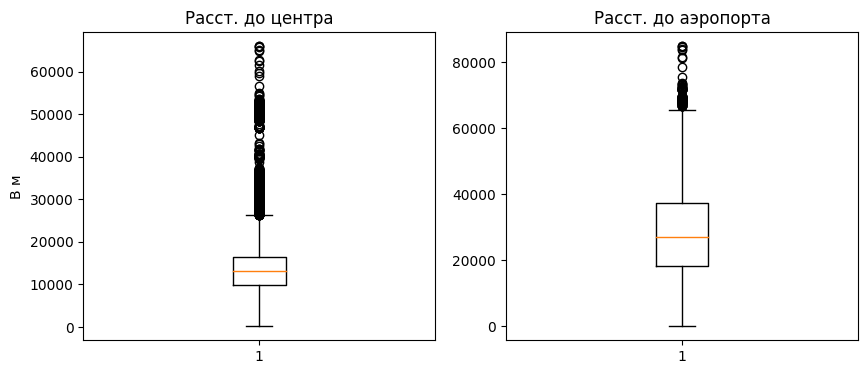

In [50]:
# Таблица для визуализации:
descr_stats = pd.DataFrame(index=data['city_centers_nearest'].describe().index)
descr_stats['Расст. до центра'] = data['city_centers_nearest'].describe()
descr_stats['Расст. до аэропорта'] = data['airports_nearest'].describe()
display(descr_stats)
# Диаграммы размаха:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].boxplot(data.loc[~(data['city_centers_nearest'].isna()), 'city_centers_nearest']) # игнорируем пропуски
axs[0].set_title('Расст. до центра')
axs[0].set_ylabel('В м')
axs[1].boxplot(data.loc[~(data['airports_nearest'].isna()), 'airports_nearest']) # игнорируем пропуски
axs[1].set_title('Расст. до аэропорта')
plt.show()

Рассмотрим детальнее объекты, существенно удаленные от центра города:

In [51]:
display(data.loc[:,'locality_name':'city_centers_nearest'].sort_values('city_centers_nearest', ascending=False).head(10))

,locality_name,airports_nearest,city_centers_nearest
9640,Молодёжное,84869.0,65968.0
5340,Молодёжное,84853.0,65952.0
577,Молодёжное,84665.0,65764.0
20746,Молодёжное,84006.0,65105.0
5218,Молодёжное,83758.0,64857.0
18884,Зеленогорск,81607.0,62706.0
2974,Зеленогорск,81355.0,62454.0
16569,Ломоносов,53042.0,61495.0
23123,Ломоносов,56896.0,60223.0
4441,Зеленогорск,78527.0,59626.0


Видим, что наибольшие расстояния до центра характерны для поселков, т.е. указано расстояние от объекта до центра Санкт-Петербурга (порядок значений проверялся на Яндекс Картах от метки поселка до Зимнего дворца). Значит, эти данные не являются аномалиями. Околонулевые значения также не являются выбросами.

Заметим, что минимальное расстояние до ближайшего аэропорта равно 0. Теоретически, этого быть не может. Посчитаем, сколько объектов находятся на расстоянии не более 5 км до аэропорта и удалим их:

In [52]:
print('Количество объектов в пределах 5 км от аэропорта:', len(data.query('airports_nearest <= 5000')))

data = data[(data['airports_nearest'] > 5000) | (data['airports_nearest'].isna())] # оставляем пропуски в выборке

Количество объектов в пределах 5 км от аэропорта: 1


Представляется логичным не анализировать прочие картографические данные (наличие парков и водоемов, расстояние до ближайших из них) на предмет аномалий. Во-первых, география Санкт-Петербурга и прилегающих территорий неоднородна, во-вторых, существенную долю данных составляют пропуски (см. п. 2.1.).

#### Срок размещения объявления

Рассмотрим описательную статистику и диаграмму размаха показателя.

count    21966.000000
mean       167.469089
std        204.635845
min          1.000000
25%         45.000000
50%         95.000000
75%        196.000000
max       1580.000000
Name: days_exposition, dtype: float64

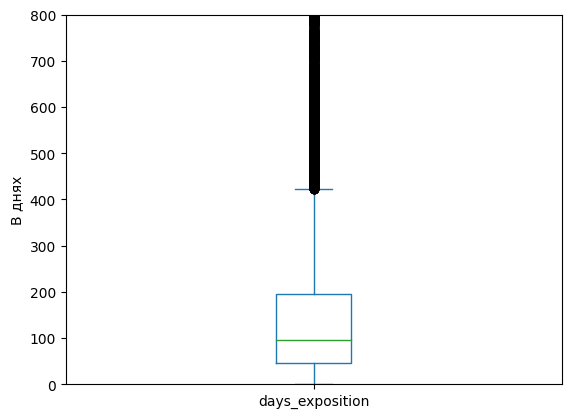

In [53]:
display(data['days_exposition'].describe())
data['days_exposition'].plot(kind='box', ylabel='В днях', ylim=(0,800)); # ограничим ось для наглядности

Заметим, что объекты, объявление о которых "висело" 0 дней, отсутствуют. Однако на гистограмме (п.2.1.) наблюдался сомнительный пик около нуля. Исходя из здравого смысла, объявление не могло быть закрыто по причине продажи объекта в течение одного дня (просмотры, составление договора и т.п. занимает время), значит, его могли снять и открыть другое с другим описанием, ценой и т.п. То есть, старое объявление оказалось нерелевантным. Рассчитаем, сколько объявлений было закрыто в течение 3 дней (неправдоподобно короткий срок для продажи).

Также, согласно диаграмме размаха, аномальными считаются объекты, продаваемые более 400 дней (ок. 13 месяцев). Исходя из здравого смысла, можно ограничить "нормальный" срок размещения объявления париблизительно тремя годами, т.е. 1000 дней. Найдем количество объектов, превышаюших заданный порог:

In [54]:
print('Количество объявлений сроком размещения не более 3 дней:', len(data.query('days_exposition <= 3')))
print('Количество объявлений сроком размещения более двух лет:', len(data.query('days_exposition >= 1000')))
print('Оба типа выбросов составляют в совокупности {0}% от выборки.'.format(
    round(outlier_count(data['days_exposition'], 1000, 3)[1]*100, 3)))

Количество объявлений сроком размещения не более 3 дней: 3
Количество объявлений сроком размещения более двух лет: 249
Оба типа выбросов составляют в совокупности 1.138% от выборки.


Удалим экстремальные значения из выборки.

In [55]:
data = data.query('3 < days_exposition < 1000')

### Контроль размера выборки

После заполнения пропусков в данных и удаления неявных дубликатов могли образоваться явные дубликаты. Также выборка уменьшилась за счет устранения выбросов в данных.

Рассчитаем, на сколько уменьшилась выборка по отношению к исходным данным.

In [56]:
data = data.drop_duplicates()

final_size = (len(data))

print('Изначально в выборке было {0} наблюдений; после обработки выборка уменьшилась на {1}% и составила {2} наблюдений.'.format(
initial_size, round((1-final_size/initial_size)*100, 1), final_size))

Изначально в выборке было 23699 наблюдений; после обработки выборка уменьшилась на 8.4% и составила 21714 наблюдений.


Сжатие выборки на 8% - допустимое значение.

### Вывод

На этапе предобработки данных были заполнены пропуски в данных, насколько это возможно:
* пропуски в данных, не зависящих от других имеющихся параметров, но поддающихся прогнозу, были заполнены медианными значениями (напр., этажность дома, высота потолков);
* пропуски в даннных, которые можно оценить исходя из других показателей в выборке, были рассчитаны (напр., жилая площадь и площадь кухни);
* пропуски в данных, поддающиеся восстановлению из здравого смысла, были восстановлены (количество балконов, признак апартаментов);
* пропуски в картографических данных были проигнорированы, т.к. их невозможно спрогнозировать без существенного искажения, а удаление строк привело бы к потере большого массива данных (более 20%).

Пропуски в данных, предоставленных пользователем, вероятнее всего имеют логическую природу: не указаны отсутствующие или непринципиальные параметры.
Пропуски в картографических данных с наибольшей вероятностью были вызваны тем, что в объявлении по каким-то причинам не был указан точный адрес объекта, что не позволило провести расчет показателей.

Также данные о дате размещения объявления были переведены в удобный для дальнейшей работы формат.

В данных были обнаружены выбросы, искажающие распределения характеристик. Наиболее критичными из них являются:

* Аномально большие по площади объекты (более 200 кв. м). Возможно, это частные дома, или какие-то другие несопоставимые объекты;
* Чрезмерно дорогие объекты (цена за кв. м более 300 тыс.руб. для Санкт-Петербурга и более 200 тыс.руб. для прочих населенных пунктов);
* Объекты, в которых жилая площадь и площадь кухни по отношению к общей площади принимают неправдоподобные значения;
* Объявления, которые размещались слишком долго (более 3 лет), либо слишком мало (не более 3 дней).

Природа таких аномалий не ясна, в связи с чем данные были удалены.
В результате предобработки выборка сократилась примерно на 8%.

## Анализ

### Расчет дополнительных параметров

Для дальнейшего анализа рассчитаем необходиые метрики, не представленные в данных напрямую. Стоимость одного кв. м в тыс.руб. была рассчитана ранее (п.3.4.2.).

In [57]:
data['publication_weekday'] = data['first_day_exposition'].dt.weekday # день недели публикации объявления
data['publication_month'] = data['first_day_exposition'].dt.month # месяц публикации объявления
data['publication_year'] = data['first_day_exposition'].dt.year # год публикации объявления
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000, 0) # расстояние до центра города в км (целое число)
# Категоризируем тип этажа:
data.loc[(data['floor']==1), 'floor_type'] = 'первый'
data.loc[(data['floor']==data['floors_total']), 'floor_type'] = 'последний'
data.loc[(data['floor_type'].isna()), 'floor_type'] = 'другой'

display(data.head())

,total_images,last_price_in_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_sqm_thousand,living_%,kitchen_%,publication_weekday,publication_month,publication_year,city_centers_nearest_km,floor_type
0,20,13.000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,755.0,95.0,120.370370,47.222222,23.148148,3,3,2019,16.0,другой
1,7,3.350,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,81.0,82.920792,46.039604,27.227723,1,12,2018,19.0,первый
2,10,5.196,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,574.0,558.0,92.785714,61.250000,14.821429,3,8,2015,14.0,другой
5,10,2.890,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,55.0,95.065789,47.368421,29.934211,0,9,2018,NaN,другой
6,6,3.700,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,NaN,155.0,99.195710,28.418231,38.605898,3,11,2017,19.0,другой


### Характеристики объектов
Рассмотрим подробнее основные параметры объектов после предобработки выборки.

#### Общая площадь

count    21714.000000
mean        56.567691
std         24.415730
min         13.000000
25%         39.500000
50%         50.600000
75%         67.000000
max        200.000000
Name: total_area, dtype: float64

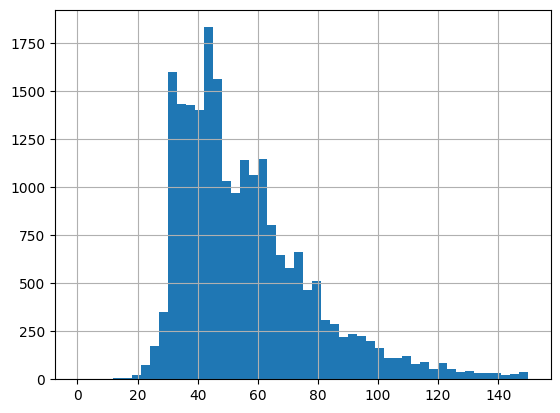

In [58]:
display(data['total_area'].describe())
data['total_area'].plot(kind='hist', bins=50, range=(0,150), grid=True)
plt.ylabel('')
plt.show()

Распределение смещено влево, присутствуют локальные пики на уровне ок. 30-35, 45 и 60 кв. м. (похоже на типичные площади для одно-, двух- и трехкомнатных квартир). Правый хвост формируется как за счет квартир комнатностью больше трех, так и нетиповыми квартирами (напр., в выборке встречается студия площадью 98 кв. м).

Наименьшая площадь квартир составляет 13 кв. м; наибольшая - 200 кв. м (более крупные объекты были удалены из выборки как аномальные). 

#### Жилая площадь

count    21714.000000
mean        32.392998
std         16.070622
min          6.258206
25%         18.500000
50%         30.000000
75%         41.000000
max        120.000000
Name: living_area, dtype: float64

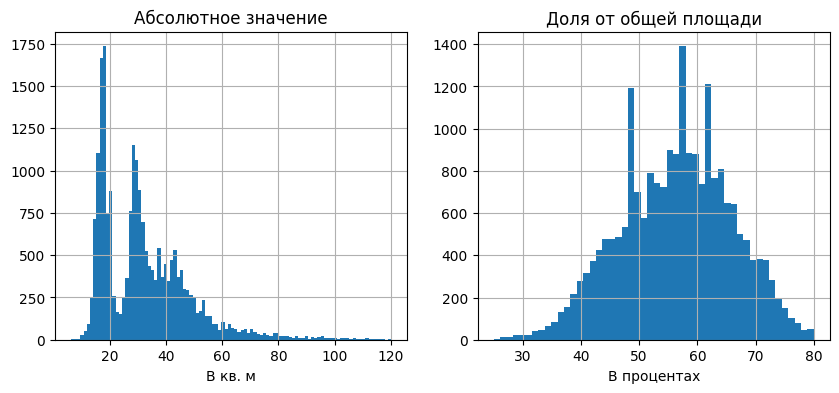

In [59]:
display(data['living_area'].describe())
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(data['living_area'], bins=100)
axs[0].set_title('Абсолютное значение')
axs[0].set_xlabel('В кв. м')
axs[0].grid(True)
axs[1].hist(data['living_%'], bins=50)
axs[1].set_title('Доля от общей площади')
axs[1].set_xlabel('В процентах')
axs[1].grid(True)

В распределении присутствуют явные пики на уровне 15-20 кв.м (характерно для однокомнатных квартир), 30-35 кв. м (похоже на двухкомнатные квартиры), и 40-45 кв. м (скорее всего, трехкомнатные квартиры). Острота пиков усугубилась по сравнению с распределением общей площади из-за заполнения пропусков медианными значениями доли жилплощади для квартир каждой комнатности (пики на графике справа). 
Минимальное значение жилплощади составляет 6,3 кв. м, максимальное - 120 кв. м (задано при обработке анномалий). Количество объектов с жилплощадью более 90 кв. м незначительно. 

#### Площадь кухни

count    21714.000000
mean         9.876601
std          4.287049
min          2.000000
25%          7.000000
50%          9.000000
75%         11.100000
max         45.000000
Name: kitchen_area, dtype: float64

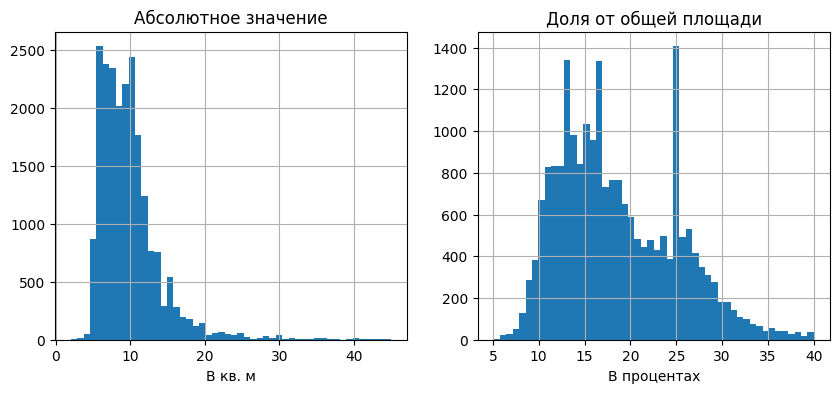

In [60]:
display(data['kitchen_area'].describe())
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(data['kitchen_area'], bins=50)
axs[0].set_title('Абсолютное значение')
axs[0].set_xlabel('В кв. м')
axs[0].grid(True)
axs[1].hist(data['kitchen_%'], bins=50)
axs[1].set_title('Доля от общей площади')
axs[1].set_xlabel('В процентах')
axs[1].grid(True)

В распределении присутствует локальный пик на уровне 6-7 кв. м (типично для хрущевок и др. типов домов советской застройки). Медиана расположена на уровне 9 кв. м, среднее - 9,9 кв. м (небольшое смещение влево.) Как и в случае с жилой площадью, пики "усилились" из-ма методики заполнения пропусков.

Минимальное значение составляет 2 кв. м (скорее всего, для студии). Количество объектов с площадью кухни 2-5 кв. м незначительно. Максимальное значение было ограничено при работе с аномалиями (45 кв.м). Количество объектов с площадью кухни более 25 кв. м. также невелико.

#### Цена объекта

Для анализа цены представляется разумным рассматривать отдельно объекты в Санкт-Петербурге и во всех других населенных пунктах.

,СПб стоимость,СПб цена,Прочие стоимость,Прочие цена
count,14231.000000,14231.000000,7483.000000,7483.000000
mean,6.680679,109.905200,3.429308,68.404288
std,4.310154,29.785345,1.820394,24.558824
min,0.012190,0.111835,0.430000,7.962963
25%,4.150000,90.595195,2.330000,51.563939
50%,5.300000,103.695150,3.150000,68.518519
75%,7.550437,122.113248,4.150000,84.615385
max,46.950000,296.610169,26.500000,182.688172


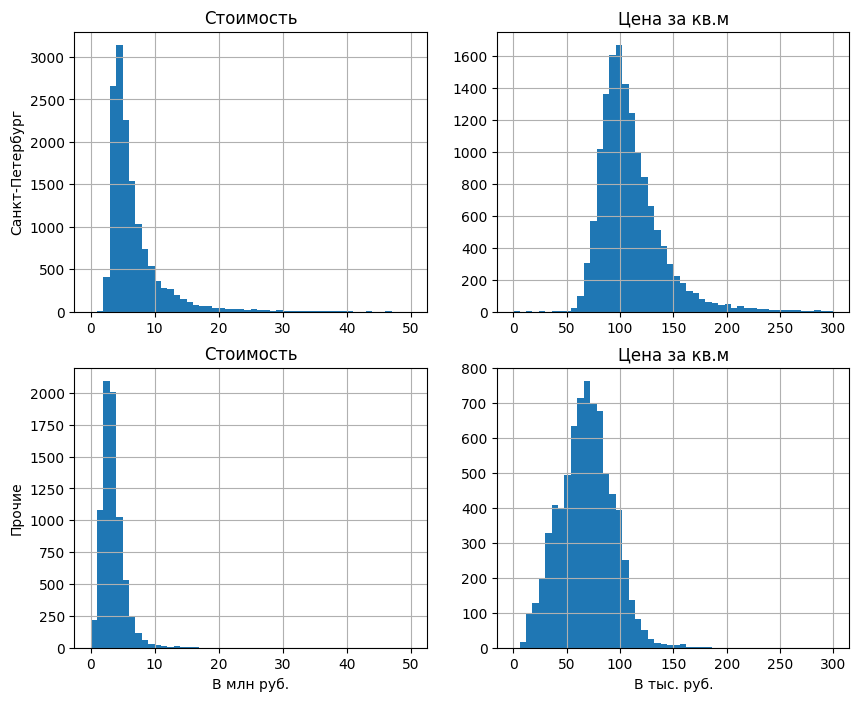

In [61]:
# таблица для визуализации:
descr_stats = pd.DataFrame(index=data['last_price_in_mln'].describe().index)
descr_stats['СПб стоимость'] = data.query('locality_name == "Санкт-Петербург"')['last_price_in_mln'].describe()
descr_stats['СПб цена'] = data.query('locality_name == "Санкт-Петербург"')['price_per_sqm_thousand'].describe()
descr_stats['Прочие стоимость'] = data.query('locality_name != "Санкт-Петербург"')['last_price_in_mln'].describe()
descr_stats['Прочие цена'] = data.query('locality_name != "Санкт-Петербург"')['price_per_sqm_thousand'].describe()
display(descr_stats)

# Гистограммы для стоимости и цены за кв. м:
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs[0,0].hist(data.query('locality_name == "Санкт-Петербург"')['last_price_in_mln'], bins=50, range=(0,50))
axs[0,0].set_title('Стоимость')
axs[0,0].grid(True)
axs[0,0].set_ylabel('Санкт-Петербург')
axs[0,1].hist(data.query('locality_name == "Санкт-Петербург"')['price_per_sqm_thousand'], bins=50, range=(0,300))
axs[0,1].set_title('Цена за кв.м')
axs[0,1].grid(True)
axs[1,0].hist(data.query('locality_name != "Санкт-Петербург"')['last_price_in_mln'], bins=50, range=(0,50))
axs[1,0].set_title('Стоимость')
axs[1,0].set_xlabel('В млн руб.')
axs[1,0].grid(True)
axs[1,0].set_ylabel('Прочие')
axs[1,1].hist(data.query('locality_name != "Санкт-Петербург"')['price_per_sqm_thousand'], bins=50, range=(0,300))
axs[1,1].set_title('Цена за кв.м')
axs[1,1].set_xlabel('В тыс. руб.')
axs[1,1].grid(True)

- **Санкт-Петербург**: Распределения и для стоимости, и для цены за кв. м тяготеют к Пуассоновским. Более половины наблюдений попадают в диапазон стоимости от 4 до 8 млн руб., по цене за кв. м - от 90 до 125 тыс.руб. (выглядит правдоподобно). Медиана расположена на уровне 5,3 млн руб., среднее - 6,7 млн руб. (для стоимости). Для цены за кв. м расхождение между медианой и средним меньше (103,4 против 110 тыс.руб.). Количество объектов ценой более 200 тыс.руб. за кв. м невелико.
- **Прочие населенные пункты**: Распределения и для стоимости, и для цены за кв. м смещены влево относительно аналогов для СПб (см. графики), что означает, что стоимости объектов и цены за кв. м в целом ниже, чем для СПб (что ожидаемо). Более 50% объектов по стоимости лежат в пределах от 2,3 до 4,2 млн руб. Медианное значение цены находится на уровне 68,5 тыс. руб. (против 103,4 тыс руб. для СПб), максимальная цена составляет 182,7 тыс руб. (почти в два раза меньше, чем максимум для СПб.)/ При этом распределение цены для прочих населенных пунктов более симметрично, чем для СПб (среднее почти равно медиане).

#### Количество комнат

count    21714.000000
mean         1.999447
std          0.959167
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

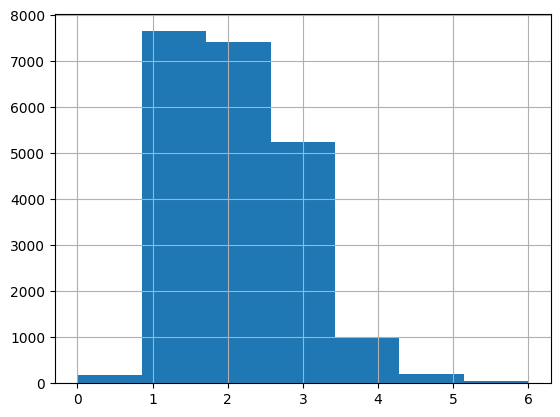

In [62]:
display(data['rooms'].describe())
data['rooms'].plot(kind='hist', bins=7, grid=True)
plt.ylabel('')
plt.show()

Наибольшее количество объектов в выборке - одно- и двухкомнатные квартиры (ок. 7,5 и 7,2 тыс. объявлений соответственно). Ок. 5 тыс. объектов составляют трехкомнатные квартиры. Такое распределение согласуется с пиками на распределениях общей и жилой площади.

#### Высота потолков

count    21714.000000
mean         2.677166
std          0.168168
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.500000
Name: ceiling_height, dtype: float64

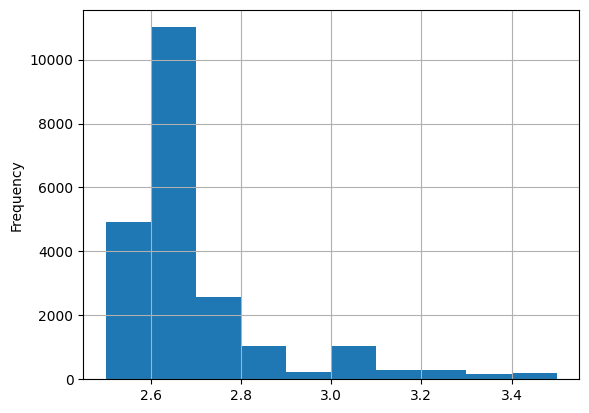

In [63]:
display(data['ceiling_height'].describe())
data['ceiling_height'].plot(kind='hist', bins=10, grid=True);

У более половины объектов высота потолков лежит в пределах 2,6-2,7 м (несколько искажено заполнением пропусков медианой в 2,65 м), что характерно для типовой застройки. Присутствует небольшое количество объектов с высотой потолков выше 3 м (возможно, дома дореволюционной постройки, нетиповые проекты).

#### Этаж и тип этажа квартиры

count    21714.000000
mean         5.879939
std          4.850674
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

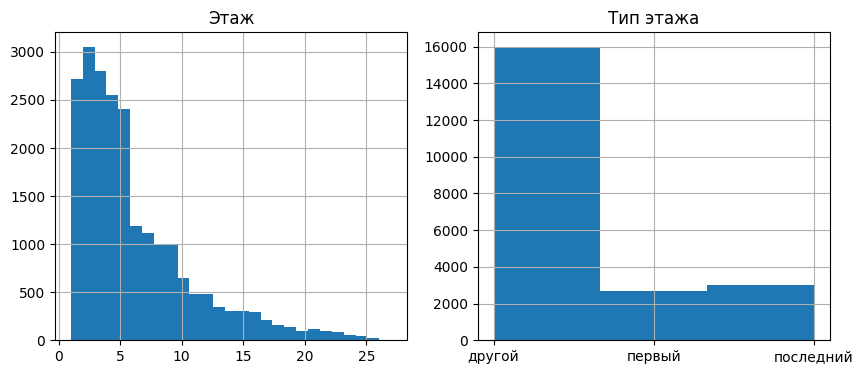

In [64]:
display(data['floor'].describe())
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(data['floor'], bins=27)
axs[0].set_title('Этаж')
axs[0].grid(True)
axs[1].hist(data['floor_type'], bins=3)
axs[1].set_title('Тип этажа')
axs[1].grid(True)

Описательная статистика для типа этажа бессмысленна, поэтому не выводилась.
Максимальное число объектов расположено на втором этаже (чуть более 3 тыс. наблюдений). Вторыми по частотности идут квартиры на 1м и 3м этажах (2,7-2,8 тыс. наблюдений). 
Количество объектов на шестом этаже скачкообразно сокращается, что скорее всего связано с ограничениями по высоте зданий в СПб и массовой застройкой пятиэтажными зданиями в советский период. Следующий скачок происходит на уровне 10го этажа.
Количество объектов на первом и последнем этажах составляет индивидуально ок. 10-15% от общей выборки.

#### Общая этажность дома

count    21714.000000
mean        10.701391
std          6.528018
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

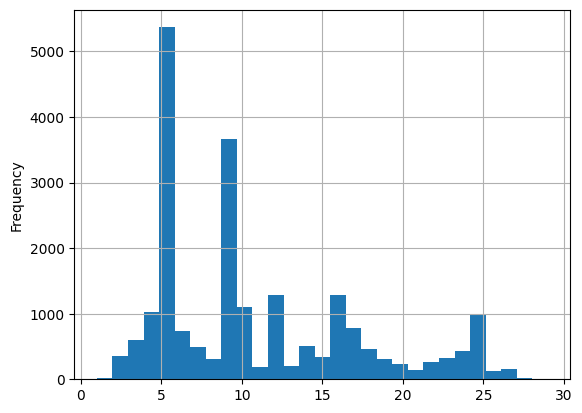

In [65]:
display(data['floors_total'].describe())
data['floors_total'].plot(kind='hist', bins=29, grid=True);

Наибольшее количество объектов расположено в пятиэтажных (ок. 5,3 тыс.) и девятиэтажных (ок. 3,7 тыс.) домах. Это хорошо объясняется особенностями застройки. Есть локальные пики  на 12, 16 и 25 этажах (видимо, типовые проекты более поздних периодов). Медианное значение составляет 9 этажей.

#### Расстояние до центра города

count    16622.000000
mean     14554.872428
std       8533.414658
min        181.000000
25%       9889.750000
50%      13279.000000
75%      16460.250000
max      65952.000000
Name: city_centers_nearest, dtype: float64

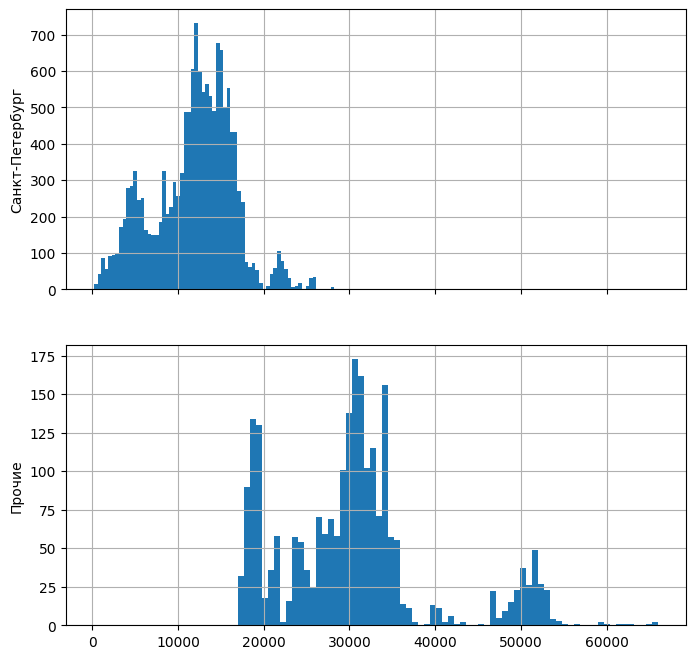

In [66]:
display(data['city_centers_nearest'].describe())
fig, axs = plt.subplots(2,1, figsize=(8,8), sharex=True)
axs[0].hist(data.query('locality_name == "Санкт-Петербург"')['city_centers_nearest'], bins=70)
axs[0].set_ylabel('Санкт-Петербург')
axs[0].grid(True)
axs[1].hist(data.query('locality_name != "Санкт-Петербург"')['city_centers_nearest'], bins=70)
axs[1].set_ylabel('Прочие')
axs[1].grid(True)

В распределении наблюдается несколько локальных пиков: на уровне 5 км, 10-15 км (наибольшее количество наблюдений), 30 км и небольшой всплеск на уровне 50 км. Более половины объектов, по которым есть информация, расположены на удалении 9-17 км от центра. Всплеск на уровне 50 км относитмя к отдаленным населенным пунктам (напр., Молодёжное, Зеленогорск). Выглядит логично, что бОльшая часть объектов располагается в Петербурге на расстоянии до 20 км от центра, а объекты в прочих населенных пунктах составляют правых хвост общего распределения.

#### Расстояние до аэропорта

count    16622.000000
mean     28986.268620
std      12840.479688
min       6450.000000
25%      18410.000000
50%      27016.000000
75%      37434.000000
max      84853.000000
Name: airports_nearest, dtype: float64

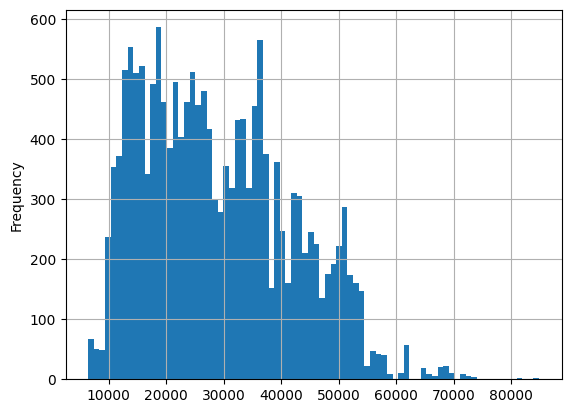

In [67]:
display(data['airports_nearest'].describe())
data['airports_nearest'].plot(kind='hist', bins=80, grid=True);

Распределение начинается с 6,4 км, что логично, учитывая, что существуют ограничния на жилую застройку в радиусе аэродромов. При этом отсутствуют такие явные пики, как на распределении до центра города. Возможно, это объясняется тем, что аэропорт отдален от центра примерно на 15 км, т.е. расположен ближе к спальным районам Петербурга и к ближайшим населенным пунктам области.

#### Расстояние до ближайшего парка

count    7137.000000
mean      493.356312
std       340.517026
min         1.000000
25%       291.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64

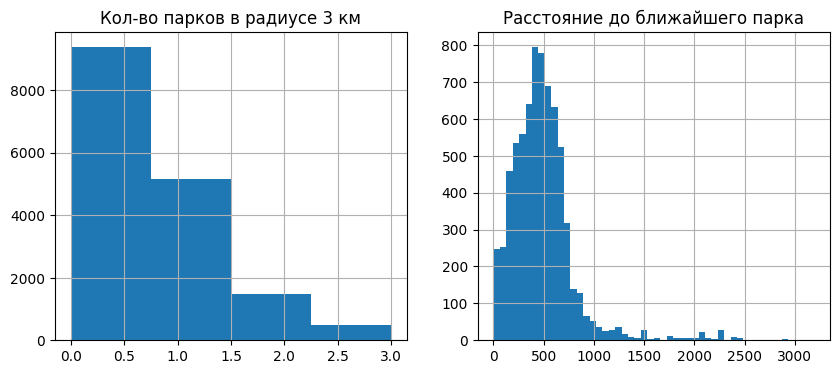

In [68]:
display(data['parks_nearest'].describe())
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(data['parks_around_3000'], bins=4)
axs[0].set_title('Кол-во парков в радиусе 3 км')
axs[0].grid(True)
axs[1].hist(data['parks_nearest'], bins=50)
axs[1].set_title('Расстояние до ближайшего парка')
axs[1].grid(True)

Заметим, что информация о расстоянии до ближайщего парка известна только для тех объектов, где в радиусе 3 км есть хотя бы один парк (таковых ок. 7 из 22 тыс. наблюдений). Из объектов, по которым имеются данные, ок. 9 тыс. объектов расположены дальше, чем 3 км до ближайшего парка. Для тех квартир, в радиусе которых есть парк, растояние составляет в среднем ок. 500 м. Количество объектов, где парк расположен далее 1 км, но в пределах 3 км, невелико.

#### День и месяц публикации объявления

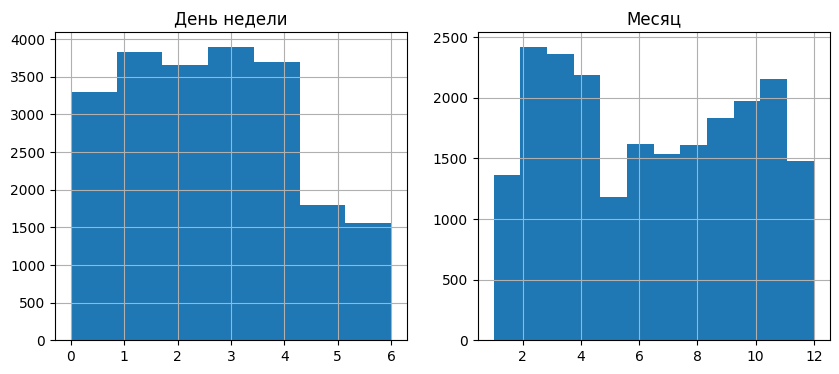

In [69]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(data['publication_weekday'], bins=7)
axs[0].set_title('День недели')
axs[0].grid(True)
axs[1].hist(data['publication_month'], bins=12)
axs[1].set_title('Месяц')
axs[1].grid(True)

Поскольку день и месяц публикации являются категориальными переменными, описательная статистика для них неприменима.
- **День недели**: меньше всего объявлений публикуется в выходные. Также меньше объявлений публикуется в понедельник, чем в остальные будние дни. Скорее всего, это обусловлено тем, что объявления размещают преимущественно риелторы, соответсвенно, их активность в выходные ниже, чем в рабочее время. уровень публикаций во вторник-пятницу примерно одинаков.
- **Месяц**: наблюдается провал в количестве объявлений в мае, связанный с большим количеством выходных и праздничных дней. Также заметно, что низкий сезон наступет в зимние месяцы (декабрь-январь) в связи с празднованием Нового года, и в летние месяцы (традиционно период отпусков). Пик размещений заметен в феврале-марте (в преддверии лета) и в ноябре (подготовка к экспозиции в течение новогодних праздников).

#### Срок размещения объявлений

count    21714.000000
mean       156.039836
std        174.900544
min          3.000000
25%         45.000000
50%         95.000000
75%        189.000000
max        999.000000
Name: days_exposition, dtype: float64

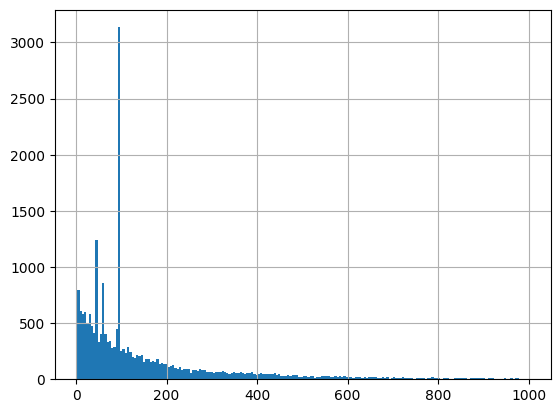

In [70]:
display(data['days_exposition'].describe())
data['days_exposition'].plot(kind='hist', bins=200, grid=True)
plt.ylabel('')
plt.show()

Напомним, что при работе с выбросами аномальными были признаны объявления, размещавшиеся до 3 дней или более 1000 дней (ок. 3х лет). Пропуски были заполнены медианным значением (крупнейший пик на распределении).
Считаем, что снятие объекта с размещения тождественно его продаже, т.к. аномально короткие сроки были удалены.

Первый квартиль составляет 45 дней, медиана - 95 дней, а среднее - 156 дней. Это говорит о том, что правый хвост распределения достаточно плавный и приближается к нулю на больших значениях (ок. 600 дней). Третий квартиль составил 189 дней.
Таким образом, быстрыми можно считать продажи до 45 дней, долгими - более 200 дней (округление третьего квартиля). 

### Зависимость общей стоимости от прочих факторов

Построим графики, показывающие зависимости общей стоимости от:
- общей площади объекта;
- жилой площади;
- площади кухни;
- количества комнат;
- типа этажа;
- даты размещения (день, месяц, год).

#### Общая площадь 
Из диаграммы рассеяния видна положительная зависимость стоимости объекта от общей площади, при этом разброс значений стоимости возрастает после отметки в 100 кв. м. Скорее всего, это обусловлено тем, что это не самые ликвидные объекты (по жизненному опыту лучше всего продаются одно- и двухкомнатные квартиры, а их площадь редко превышает 100 кв. м). Соответственно, на стоимость оказывает существенное влияние расположение, ремонт и т.п.

При этом явная зависимость цены за кв. м от общей площади не прослеживается.

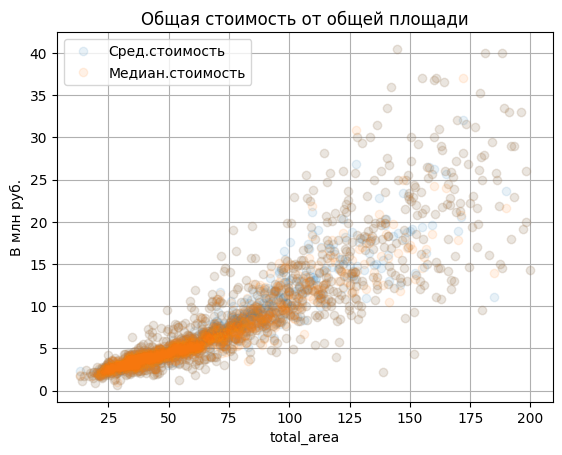

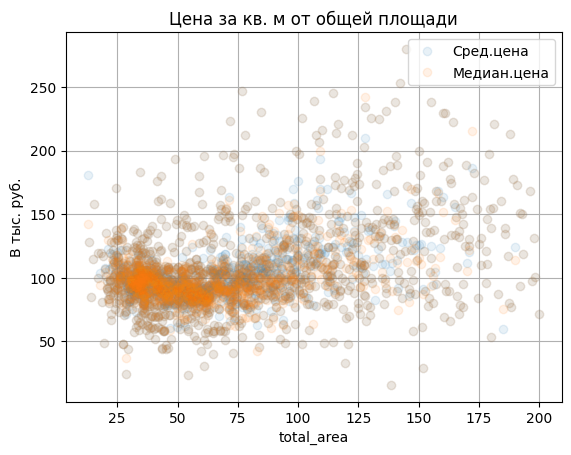

In [71]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='total_area', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, alpha=0.1, title='Общая стоимость от общей площади')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, alpha=0.1, title='Цена за кв. м от общей площади');

#### Жилая площадь
Ситуация аналогична общей площади. Разброс стоимости увеличивается после 60 кв. м.

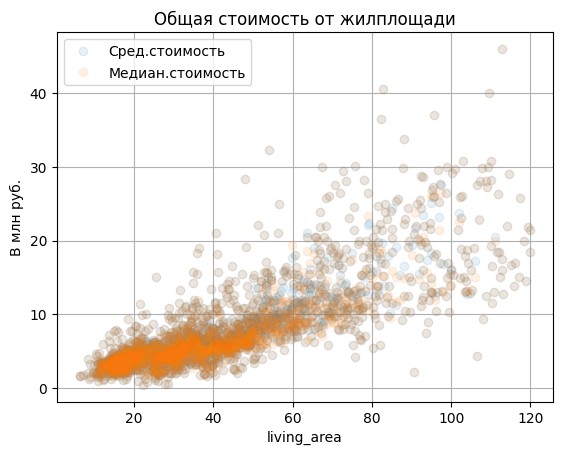

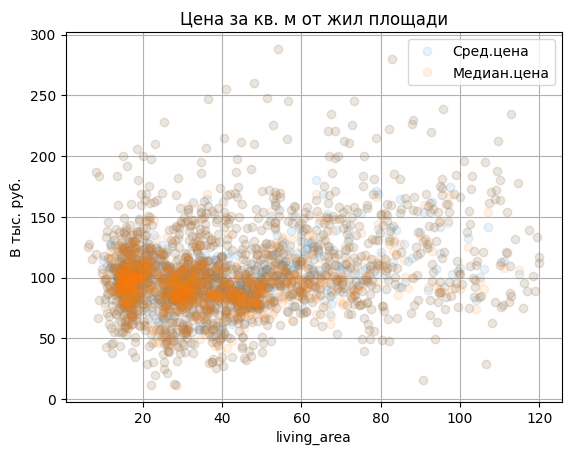

In [72]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='living_area', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, alpha=0.1, title='Общая стоимость от жилплощади')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, alpha=0.1, title='Цена за кв. м от жил площади');

#### Площадь кухни
Аналогично жилой площади, заметна положительная зависимость, однако разброс стоимости резко увеличивается после отметки в 10 кв. м.

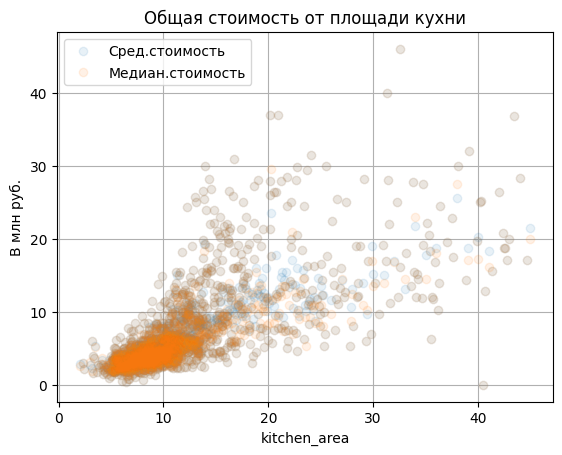

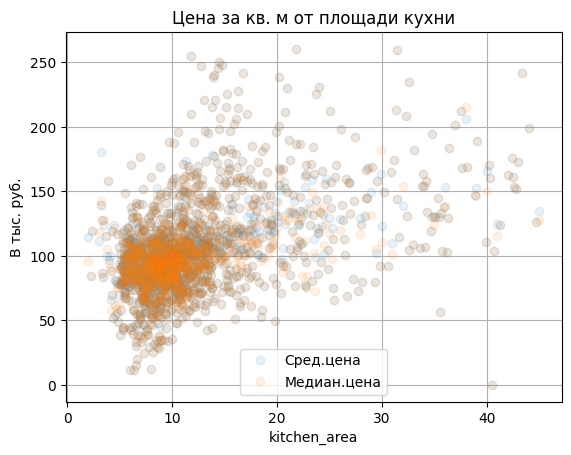

In [73]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='kitchen_area', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, alpha=0.1, title='Общая стоимость от площади кухни')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, alpha=0.1, title='Цена за кв. м от площади кухни');

#### Количество комнат
Видим, что стоимость объекта в целом возрастает при росте комнатности. При этом цена за кв. м сокращается при росте количества комнат от 0 (студии) до 3х, т.к. падает ликвидность объекта в целом (большие квартиры сложнее продать). Дальнейшие колебания могут быть вызваны относительно небольшим кол-вом наблюдений и, соответсвенно, большей подверженностью выбросам (увеличились различия меджу средним и медианным значением).

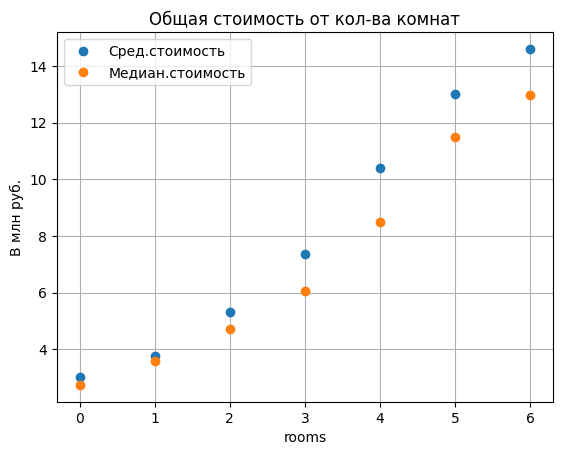

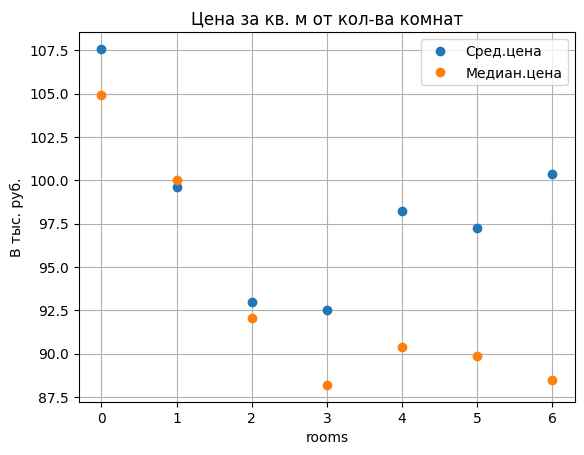

In [74]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='rooms', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, title='Общая стоимость от кол-ва комнат')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, title='Цена за кв. м от кол-ва комнат');

#### Тип этажа дома
Заметно, что квартиры на первом этаже стоят в целом меньше всего; стоимость объектов на последнем этаже также ниже, чем на "промежуточных" этажах. Такая же динамика характерна и для цены за кв. м.

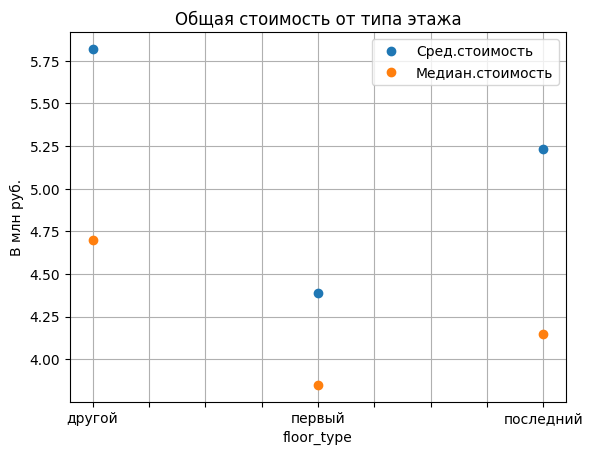

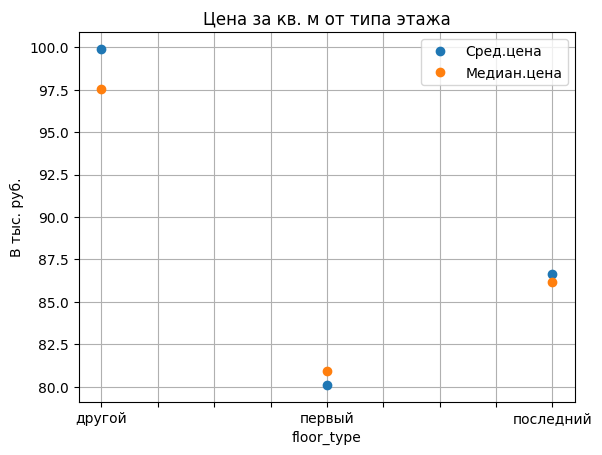

In [75]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='floor_type', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, title='Общая стоимость от типа этажа')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, title='Цена за кв. м от типа этажа');

#### День недели публикации объявления
Заметно, что средняя стоимость объектов в объявлениях, размещенных в выходные, несколько ниже, чем в будни (5,4 млн руб. против ок. 5,6 млн руб.). При этом цена за кв. м колеблется достаточно сильно и хаотично. Необходим дальнейший анализ.

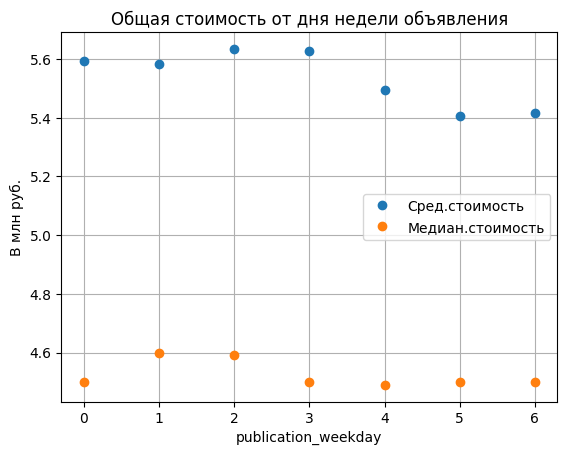

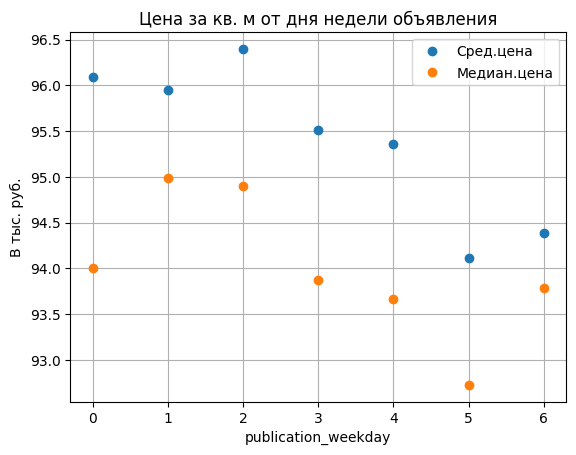

In [76]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='publication_weekday', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, title='Общая стоимость от дня недели объявления')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, title='Цена за кв. м от дня недели объявления');

#### Месяц публикации

В динамике общей стоимости в зависимости от месяца публицации объявления заметен провал в июне. Медианное значение цены за кв. м хаотично колеблется в пределах 92-95 тыс. руб. за кв. м. Явная зависимость не прослеживается, необходим дополнительный анализ.

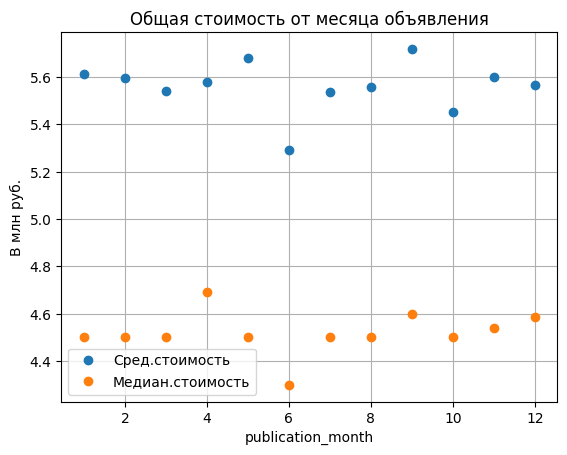

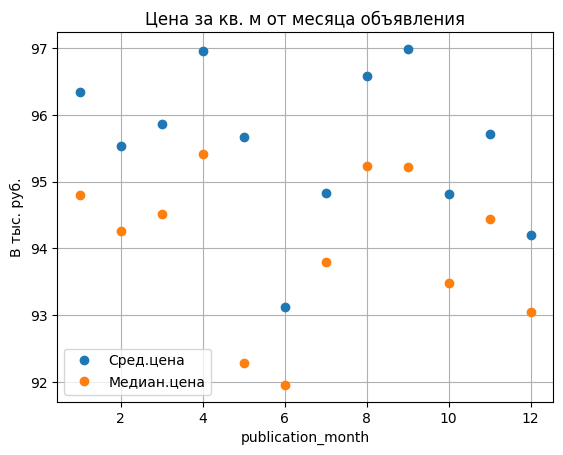

In [77]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='publication_month', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, title='Общая стоимость от месяца объявления')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, title='Цена за кв. м от месяца объявления');

#### Год публикации
Из диаграммы следует, что и медианная стоимость, и медианная цена за кв. м упали в 2015 г. по отношению к 2014 г. Затем цена за кв. м незначительно выросла в 2016-2017 гг., темпы роста выросли в 2018-2019 гг. При этом стоимость стагнировала в течение 2016-2018 гг., а затем немного выросла в 2019 г. Такая динамика свидетельствует об изменении структуры рынка: с 2017 г. экспонируются объекты с меньшей площадью. Для исследования динамики средних цен необходим более глубокий анализ экономики в укащанные периоды.

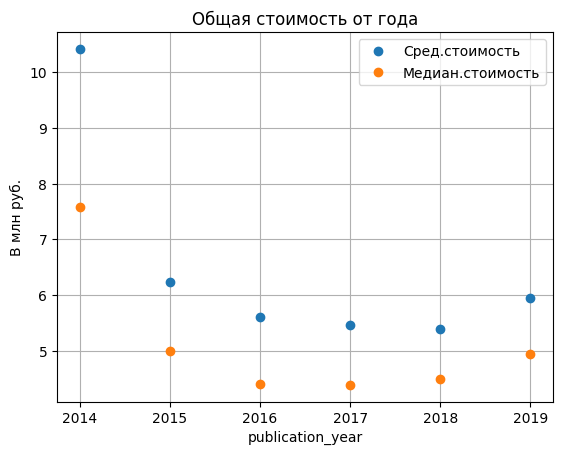

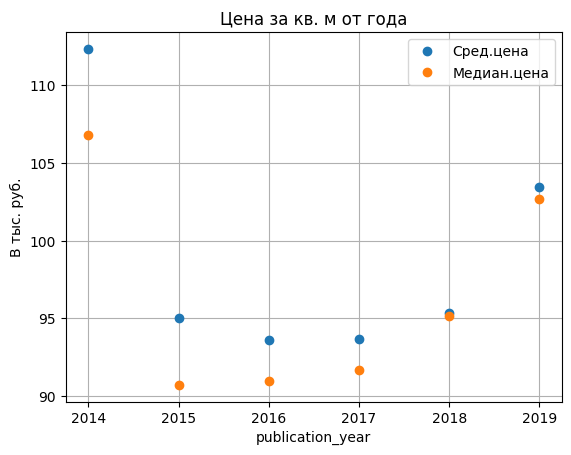

In [78]:
# Находим средние и медианы в зависимости от анализируемого фактора:
pivot=data.pivot_table(index='publication_year', values=['last_price_in_mln', 'price_per_sqm_thousand'], aggfunc=['mean', 'median'])
pivot.columns = ['Сред.стоимость', 'Сред.цена', 'Медиан.стоимость', 'Медиан.цена']

# Наносим на графики:
pivot.plot(y=['Сред.стоимость', 'Медиан.стоимость'], style= 'o', 
           ylabel='В млн руб.', grid=True, title='Общая стоимость от года')
plt.show()
pivot.plot(y=['Сред.цена', 'Медиан.цена'], style= 'o', 
           ylabel='В тыс. руб.', grid=True, title='Цена за кв. м от года');

#### Расчет коэффициентов корреляции
Для уточнения анализа зависимостей между факторами посчитаем коэффициенты ранговой корреляции Спирмена (т.к. данные о дате публицации объяыления, в сущности, являются категориальными):

In [79]:
corr_parameters = data[['last_price_in_mln', 
                        'total_area', 
                        'living_area',
                        'kitchen_area',
                        'rooms',
                        'floor_type',
                        'publication_weekday',
                        'publication_month',
                        'publication_year']]
display(corr_parameters.corr(method='spearman'))

,last_price_in_mln,total_area,living_area,kitchen_area,rooms,publication_weekday,publication_month,publication_year
last_price_in_mln,1.000000,0.727506,0.627101,0.565949,0.517833,-0.015167,0.002844,0.015069
total_area,0.727506,1.000000,0.929393,0.498991,0.851679,-0.006593,0.006082,-0.045994
living_area,0.627101,0.929393,1.000000,0.262686,0.911673,-0.003109,-0.001248,-0.038197
kitchen_area,0.565949,0.498991,0.262686,1.000000,0.115764,-0.008067,0.018489,-0.038795
rooms,0.517833,0.851679,0.911673,0.115764,1.000000,-0.001087,-0.000839,-0.030165
publication_weekday,-0.015167,-0.006593,-0.003109,-0.008067,-0.001087,1.000000,0.008355,-0.010609
publication_month,0.002844,0.006082,-0.001248,0.018489,-0.000839,0.008355,1.000000,-0.290023
publication_year,0.015069,-0.045994,-0.038197,-0.038795,-0.030165,-0.010609,-0.290023,1.000000


Как следует из расчетов, наиболее сильную корреляцию со стоимостью объекта демонстрируют общая площадь (коэфф. +0,72). Жилая площадь, площадь кухни и количество комнат также имеют положительное влияние на стоимость, однако не столь сильное (коэфф. от +0,63 до +0,52). Стоимость не зависит от даты публикации объявления (коэфф. близки к 0).
При этом корреляция между общей, жилой площадью и количеством комнат почти полная (парные коэф. от +0,93 до +0,85). Для построения модели в дальнейшем и уточнения выводов необходимо будет избавиться от зависисмости объясняющих переменных друг от друга.

### Зависимость цены за кв. м от расстояния до центра

Рассчитаем средневзвешенную цену за кв. м в топ-10 населенных пунктах по количеству объявлений. Для этого разделим общую стоимость всех объектов в данном поселении на общую квадратуру этих объектов. Таким образом цена за кв. м окажется взвешена по площади объектов. Также добавим среднее расстояние объектов в населенном пункте до центра города:

In [80]:
# Найдем населенные пункты с максимальным количеством объявлений:
major_localities = data.pivot_table(index='locality_name', values='total_area', aggfunc='count') #количество по всем пунктам
major_localities.columns = ['publications_num']
major_localities = major_localities.sort_values('publications_num', ascending=False).head(10) # оставляем только 10 крупнейших
# Посчитаем средневзвешенную цену для каждого населенного пункта:
avg_prices = data.pivot_table(index='locality_name', values=['last_price_in_mln', 'total_area'], aggfunc='sum')
avg_prices.columns = ['total_cost_in_mln', 'total_area']
avg_prices['price_per_sqm_thousand'] = round(avg_prices['total_cost_in_mln'] / avg_prices['total_area'] * 1000, 3)
# Добавим рассчитаные цены к данным о количестве объявлений:
major_localities = major_localities.join(avg_prices['price_per_sqm_thousand'], how='left')
# Найдем среднее расстояние до центра города в км и добавим к данным о кол-ве объявлений:
avg_distances = data.pivot_table(index='locality_name', values='city_centers_nearest_km')
major_localities = major_localities.join(avg_distances, how='left')
display(major_localities)
# Выделим населенные пункты с максимальной и минимальной стоимостью за кв. м:
print('Максимальная цена - в поселении {0} ({1} тыс. руб. за кв. м), минимальная - в поселении {2} ({3} тыс. руб. за кв.м).'.format(major_localities['price_per_sqm_thousand'].idxmax(),
                                                                     major_localities['price_per_sqm_thousand'].max(),
                                                                     major_localities['price_per_sqm_thousand'].idxmin(),
                                                                     major_localities['price_per_sqm_thousand'].min()
                                                                    )
     )

,publications_num,price_per_sqm_thousand,city_centers_nearest_km
locality_name,,,
Санкт-Петербург,14231,111.989,11.878434
Мурино,548,83.460,22.000000
Кудрово,435,94.160,NaN
Шушары,419,76.229,24.276850
Всеволожск,368,66.523,NaN
Пушкин,336,103.430,28.791667
Колпино,323,73.472,32.021672
Парголово,320,87.497,19.962500
Гатчина,289,68.522,NaN


Максимальная цена - в поселении Санкт-Петербург (111.989 тыс. руб. за кв. м), минимальная - в поселении Выборг (58.4 тыс. руб. за кв.м).


Ожимаемо, самая высокая цена за кв. м наблюдается в Петербурге (ок. 112 тыс. руб. за кв. м). При этом нельзя сказать, что цена за кв. м падает при удалении от Санкт-Петербурга: напр., цена в Пушкине (28 км. от центра СПБ) выше, чем в Мурино или Шушарах (22 км и 24 км от центра соответственно). Т.е. цена на кв. м определяется не только расстоянием до центра Санкт-Петербурга, но и другими факторами.

Рассмотрим, как средняя цена за кв. м зависит от растояния до центра в рамках одного города (Санкт-Петербурга как крупнейшего из выборки).

Коэффициент корреляции между средней ценой и расстоянием до центра: -0.655


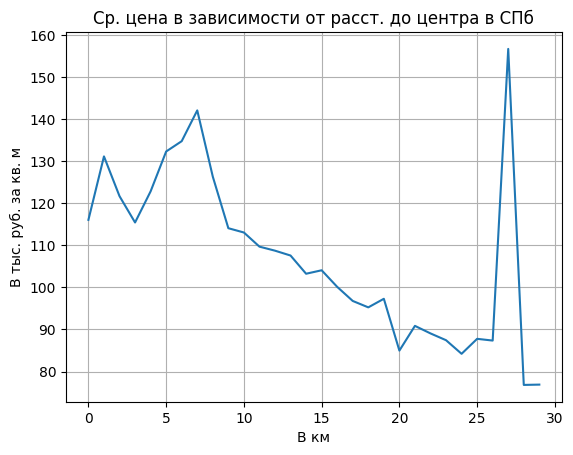

In [81]:
# Найдем средневзвешенную цену для каждого км удаления от центра для СПб:
spb_distances = (data.query('locality_name == "Санкт-Петербург"').
                 pivot_table(index='city_centers_nearest_km', values=['last_price_in_mln', 'total_area'], aggfunc='sum'))
spb_distances['avg_price_per_sqm_thousand'] = round(spb_distances['last_price_in_mln'] / spb_distances['total_area']*1000, 3)
spb_distances['city_center_distance'] = spb_distances.index

# Постороим график:
spb_distances.plot(y='avg_price_per_sqm_thousand', legend=False, grid=True,
                   title='Ср. цена в зависимости от расст. до центра в СПб',
                   xlabel='В км', ylabel='В тыс. руб. за кв. м')
print('Коэффициент корреляции между средней ценой и расстоянием до центра:', 
      round(spb_distances['avg_price_per_sqm_thousand'].corr(spb_distances['city_center_distance']), 3)
     )

На графике видно, что цена в целом падает при удалении от центра (участок от 5 до 25 км). Флуктуации на отрезках 0-5 км и 25-30 км могут быть вызваны небольшим количеством наблюдений, подходящих под условия (см. п. 4.2.9.).

### Вывод

В выборке, полученной после предобработки данных, более 60% объектов расположены в Санкт-Петербурге. Доминируют одно- и двухкомнатные объекты; у половины объектов в выборке общая площадь каходится в пределах 39-67 кв. м (медиана - 50 кв. м). Больше половины объектов находятся в пределах 10-20 км от цетра Санкт-Петербурга. Объявления о продаже размещались в среднем 156 дней, медианный показатель - 95 дней.
Таким образом, быстрыми можно считать продажи до 45 дней (первый квартиль), долгими - более 200 дней (округление третьего квартиля).

Общая стоимость объекта главным образом определяется общей площадью, количеством комнат, жилой площадью и площадью кухни (чем больше площади и комнатность, тем выше стоимость). Дата публикации объявления не оказывает существенного влияния на стоимость.
При этом, для дальнейшего построения модели необходимо исключить взаимозависимость между общей площадью, жилой площадью и размером комнат.

Также была исследована средняя цена за кв. м в десяти населенных пунктах с наибольшим количеством объявлений. Максимальная цена, как и ожидалось, наблюдается в Петербурге (ок. 112 тыс. руб. за кв. м), наименьшая - в Выборге (ок. 58 тыс. руб. за кв. м). При этом нельзя однозначно сказать, что средняя цена в том или иной населенном пункте определяется расстоянием до центра агломерации.

При рассмотрении средней цены за кв. м внутри Санкт-Петербурга заметно снижение средней цены при удалении от центра города (коэффициент корреляции составляет -0,654).

## Общий вывод

Цель исследования заключалась в поиске факторов, влиящих на общую стоимость объектов недвижимости, и характера их влияния. Результат исследования может быть использован в дальнейшем для создания автоматизированной системы отслеживания аномалий и мошеннических действий.

Для анализа использовался архив объявлений о продаже квартир в Санкт-Петербурге и ближайших населенных пунктах. Изначально выборка состояла из ок. 24 тыс. наблюденй и 22 параметров. Параметры включали как информацию об объекте, заполненную пользователем (стоимость, общая площадь, жилая площадь, наличие балконов и т.п.), так и картографические данные (расстояния до центра города и аэропорта, наличие в радиусе 3 км парков и т.п.). В 15 из 22 параметрах присутсвовали пропуски в данных.

Для дальнейшего анализа пропуски были по возможности устранены. Данные, содержащие пропуски в картографических показателях, не были удалены из выборки, т.к. это привело бы к потере существенной части информации. При этом спрогнозировать такие пропущенные значения проблематично, в результате чего пропуски остались незаполненными.

Пропуски в данных, предоставленных пользователем, вероятнее всего имеют логическую природу: не указаны отсутствующие или непринципиальные параметры.
Пропуски в картографических данных с наибольшей вероятностью были вызваны тем, что в объявлении по каким-то причинам не был указан точный адрес объекта, что не позволило провести расчет показателей.

Данные о дате размещения объявления были переведены в удобный для дальнейшей работы формат, устранены дубликаты в написании названий населенных пунктов.

Кроме того, в данных были обнаружены выбросы, искажающие распределения характеристик. Наиболее критичными из них являются:

* Аномально большие по площади объекты (более 200 кв. м). Возможно, это частные дома, или какие-то другие несопоставимые объекты;
* Чрезмерно дорогие объекты (цена за кв. м более 300 тыс.руб. для Санкт-Петербурга и более 200 тыс.руб. для прочих населенных пунктов);
* Объекты, в которых жилая площадь и площадь кухни по отношению к общей площади принимают неправдоподобные значения;
* Объявления, которые размещались слишком долго (более 3 лет), либо слишком мало (не более 3 дней).

Природа таких аномалий не ясна, в связи с чем данные были удалены.
В результате предобработки выборка сократилась примерно на 8%.

После устранения описанных выше проблем в данных были изучены основные характеристики объектов в выборке:
* Более 60% объектов расположены в Санкт-Петербурге.
* Доминируют одно- и двухкомнатные объекты
* У половины объектов в выборке общая площадь каходится в пределах 39-67 кв. м (медиана - 50 кв. м). 
* Больше половины объектов находятся в пределах 10-20 км от цетра Санкт-Петербурга. 
* Объявления о продаже размещались в среднем 156 дней, медианный показатель - 95 дней. 

Затем исследовалась зависимость общей стоимости объекта от следующих параметров:
- общая площадь,
- жилая площадь,
- площадь кухни,
- количество комнат,
- этажа, на котором расположен объект,
- день недели, месяц и год размещения объявления.

Общая стоимость объекта главным образом определяется общей площадью, количеством комнат, жилой площадью и площадью кухни (чем больше площади и комнатность, тем выше стоимость). Квартиры на первом этаже стоят в целом меньше всего, соимость квартир на последнем этаже также ниже, чем на "промежуточных" этажах. Дата публикации объявления не оказывает существенного влияния на стоимость.
При этом, для дальнейшего построения модели необходимо исключить взаимозависимость между общей площадью, жилой площадью и размером комнат.

Также была исследована средняя цена за кв. м в десяти населенных пунктах с наибольшим количеством объявлений. Максимальная цена, как и ожидалось, наблюдается в Петербурге (ок. 112 тыс. руб. за кв. м), наименьшая - в Выборге (ок. 58 тыс. руб. за кв. м). При этом нельзя однозначно сказать, что средняя цена в том или иной населенном пункте определяется расстоянием до центра агломерации.

При рассмотрении средней цены за кв. м внутри Санкт-Петербурга заметно снижение средней цены при удалении от центра города.